In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [331]:
def lambda_initaliser(n): #bigger Lambda means smaller effective updates, more regularisation, more precise prior
#     return (np.ones((n,n))+np.eye(n))*1e1
#     return (-1*np.ones((n,n))+np.eye(n)*(n))*1
#     return (np.ones((n,n))+np.diag(np.random.rand(n))+np.random.rand(n,n)*0.1)*1
    return (np.eye(n))/n**2#/np.sqrt(n)
#     return np.ones((n,n))*1e-4

In [329]:
def initialiser_function(rows,columns):
#     return np.random.randn(rows,columns)
#     inits= np.zeros((rows,columns))+np.random.randn(rows,columns)*0.1
    inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)*0.01

#     inits=(np.random.randn(rows,columns))*np.sqrt(6)/np.sqrt(rows+columns)

#     inits=(np.random.randn(rows,columns)*2)*np.sqrt(6)/np.sqrt(rows+columns)*0
#     inits=(np.random.randn(rows,columns))*0.1#*np.sqrt(6)/np.sqrt(rows+columns)
#     inits=(np.random.rand(rows,columns)*2-1)*np.sqrt(6)/np.sqrt(rows+columns)

#     inits[0,:]=np.ones((1,columns))
    return inits


In [7]:
def bias_initialiser(n):

    return (np.random.randn(1,n)*2-1)*np.sqrt(6)/np.sqrt(n+1)


In [140]:
class NNet:
    # this is a standard normal network using ReLU activation functions
    # and an identity as the output activation function
    # it is trained using standard gradient descent with gradients calculated using backprop
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function):
        
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        self.weights=[] #initialise weights, the bias vectors are treated as an extra row of the weights
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        
        #initialise variables calculated when using the network
        self.activated=[] 
        self.z=[]
        self.a=[]
        self.Delta=[]
        
    def forward(self,x):
        # Does a forward pass of the network, and saves relevent variables
        
        #clear saved variables for forward pass
        self.z=[]
        self.a=[]
        self.activated=[]
        
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to the x to account for the bias

        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

            if not ii== len(self.weights)-1: #if not the end
                x=np.hstack([np.ones((x.shape[0],1)),x]) # append 1 to account for the bias
                self.activated.append(x>0) #save whether the neurons were activated
                self.z.append(x) 
                x=x*self.activated[ii] #apply ReLU activation function
                self.a.append(x) #save activations

                if np.sum(np.sum(self.activated[ii]))==0: #if there are no activations in a layer
                    print('No activations')
            
        self.z.append(x) #append the final things
        
        # for this case we are using the identity as the final activation function because we want to 
        # approximate functions with negative values
        # this means that the neurons in the final layer are always activated
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x
    
    def gradients(self,x,Y):
        # calculates the gradients of neural network using standard back propagation
        
        Delta=[] #Delta=d(loss)/dz=d(loss)/da*gradsigma(z)
        
        #the self.activated variable is the effectively the grad of the activation function

        Delta.append((Y-self.a[-1])*self.activated[-1]) #calculate Delta for the final layer
        for ll in range(len(self.weights)-2,-1,-1):
            #calculate Delta for the other layers
            Delta.insert(0,((Delta[0] @ self.weights[ll+1].T)*self.activated[ll])[:,1:])
        
        grad_w=[] #calculating the gradient of the error with respect to the weights
        grad_w.append(Delta[0].T @ np.hstack([np.ones((x.shape[0],1)),x]))
        for ll in range(len(Delta)-1):
            grad_w.append(Delta[ll+1].T @ self.a[ll])
            
        return grad_w
    
    def train(self,xx,YY,alpha=0.01, print_error=False):
        #trains the neural network for one epoch, one sample at a time using standard SGD
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        for ii in range(len(YY)):
            # for each piece of data
            x=xx[ii,:]
            x=x.reshape((1,x.shape[0]))
            Y=YY[ii,:]
            
            Y_out=self.forward(x) #do a forward pass
            error_out=np.sum((Y-Y_out)**2) #calcuate the loss, in this case the square error
            grad_w=self.gradients(x,Y) #calculate the gradients
#             print(self.biases)
            for ll in range(len(self.weights)):
                # update the weights using the gradients
                self.weights[ll]=self.weights[ll]+alpha*grad_w[ll].T
                
            if print_error: #print the error if you want
                print(str(ii)+': Error: '+ str(error_out))
            

In [9]:
class BNet5:
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.weights=[]
        self.biases=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
#         print(x.shape)
        self.z=[]
        self.a=[]
        self.activated=[]
#         assert len(x)==self.input_dim
        x=np.hstack([np.ones((x.shape[0],1)),x])
        all_activated=1
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii]

#             self.activated.append(x>0)
#             self.z.append(x)
            if not ii== len(self.weights)-1:
                x=np.hstack([np.ones((x.shape[0],1)),x])
                self.activated.append(x>0)
                self.z.append(x)
                x=x*self.activated[ii]
                self.a.append(x)
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0:
#                     print('No activations')
                    all_activated=0
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
#             print(self.activated)
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,attempt_numbers=5,total_info=1):
        c=total_info/passes
        sample_used=np.zeros(len(xx))
        for attempt in range(attempt_numbers):
            
            for ii in range(len(YY)):
                
                if not sample_used[ii]:
                    x=xx[ii]
                    x=x.reshape((1,x.shape[0]))
                    Y=YY[ii]
                    Y=Y.reshape((1,Y.shape[0]))
        #             print(Y.shape)
                    Y_out,all_activated=self.forward(x)
#                     all_activated=1
                    error_out1=np.sum((Y-Y_out)**2)
                    if all_activated:
                        sample_used[ii]=1

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x)

                            for ll in range(len(self.weights)-1,-1,-1):
            #                     print(ll)
                                xl=self.a[ll-1]
                                if ll==len(self.weights)-1:
                                    Yl=Y
                                    w=self.weights[ll]
                                else:
            #                         print(Yl.shape)
            # #                         print(np.linalg.pinv(self.weights[ll+1]).shape)
            #                         print(np.linalg.pinv(w).shape)

                                    Yl=Yl @ np.linalg.pinv(w)
                                    Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
            #                         print(Yl.shape)
                                    Yl=Yl[:,self.activated[ll][0,1:]]
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                                L=self.Lambda[ll]

            #                     print(xl.T.shape)
            #                     print(Yl.shape)
            #                     print(L.shape)
            #                     print(w.shape)
            #                     print(w)
            #                     print(w.shape)
            #                     print(Yl.shape)

            #                     print(xl.shape)
            #                     print(w.shape)
            #                     print(np.linalg.inv(c*(xl.T @ xl) + L).shape)
            #                     print(((xl.T @ Yl)).shape)
            #                     print(L.shape)
                                w=np.linalg.pinv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
            #                     print(w)
                                w=np.nan_to_num(w)
                                L=c*xl.T @ xl + L
                                if ll==len(self.weights)-1:
                                    self.weights[ll]=w
                                else:
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L
            #                     print(self.weights[ll])
                    else:
                        print('not today')
                    Y_out,all_activated=self.forward(x)

                    error_out2=np.sum((Y-Y_out)**2)

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2))
            print(sum(sample_used))

In [142]:
def find_Y(Y,w1,X0): 
    # This function finds the new Y value for the layer, by going 'backwards' through the matrix
    # initally we had X0 @ w0 = Y, and then updated w0 -> w1, so now we solve X1 @ w1 = Y for X1
    # this is often under determined, and so we find the X1 which is closest (L2 norm) to X0

    delta=w1 @ np.linalg.inv(w1.T @ w1) @ (Y - X0 @ w1).T
    X1 = X0+delta.T

    # remember to kill bias if needed
    return X1

In [291]:
class BNet6:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    # For training this one does all the passes for one sample in a row, rather than running through all the data
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample

                if sample_used[ii]<passes: #if this data hasn't already been used too many times
                    x=xx[ii,:]
                    x=x.reshape((1,x.shape[0]))                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))

                    Y_out,all_activated=self.forward(x) #do a forward pass
                    # Y_out is just used for printing the error
                    # all_activated = 1 if all layers have at least one activated neuron
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2) #calculate MSE
                    if all_activated:
                        sample_used[ii]+=1 #count the times this sample has been used

                        for ps in range(passes):
                            Y_out,all_activated=self.forward(x) #do a forward pass each time to calculate new values of self.a etc

                            for ll in range(len(self.weights)-1,-1,-1):
                                #updating the weight matrices, starting from the final one

                                xl=self.a[ll-1] #set xl to the 'input' of the weight matrix
                                
                                if ll==len(self.weights)-1: 
                                    # if we are updating the final weight matrix (which we do first)
                                    # then set Yl to the actual value of Y, and w to the weight matrix
                                    Yl=Y
                                    w=self.weights[ll] #this is a tempory variable for the weights which get updated
                                    # because we are using the identity as the final acivation function 
                                    # this is just the weight matrix, we don't need to modify it
                                else:

                                    # various options for doing the 'inversion' step
                                    # can simply pseudoinvert the weights, and the normalise to the bias
#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise
                                    
                                    # can use our fancy invert method to find the closest Yl to a_l
                                    # here we just entirely leave out the bias
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])
                                    
                                    # or can use our fancy method, but include the bias and normalise to it
                                    Yl= find_Y(Yl, w, self.a[ll])
                                    Yl=Yl[:,1:]/Yl[0,0]
                                    
                                    # I think there may be a better way to do this, which *forces* the first element of
                                    # Yl to be one (which we would then remove)
                                    # and makes the rest of Yl as close to a_l as possible
                                
    
                                    Yl=Yl[:,self.activated[ll][0,1:]] # select only the elements of Yl which correspond to activations
                
                                    w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations
                
                
                                L=self.Lambda[ll] # make a tempory variable for Lambda 
                                
                                # now we have the actual updating!
                                # update the weight matrix
                                w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)
                                
#                                 w=np.nan_to_num(w)
                                # update the Lambda
                                L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])

                                if ll==len(self.weights)-1: #if updating the final layer, just set it equal to w
                                    self.weights[ll]=w
                                else: #otherwise just update the elements which were updated
                                    self.weights[ll][:,self.activated[ll][0,1:]]=w
                                self.Lambda[ll]=L # set Lambda to the new Lambda
                            
                    else: # if it failed because there were no activations
#                         print('not today')
                        sample_attempted[ii]+=1 # count fails for this sample
                    Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes

                    error_out2=np.sum((Y-Y_out)**2) # calculate the new error

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2)
                              +' \nTotal fails (no activations): ' +str(int(sum(sample_attempted))), end="\n\r", flush=True)

            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                # if for each sample, it has either been used the correct number of times
                # or been attempted and failed the max number of times 
                # then end the training process
                still_going=False

In [309]:
class BNet7:
    # Neural net that can be trained using approximate (dodgy) Bayesian updating
    # The forward pass works just like a standard neural net
    
    def __init__(self,hidden_layer_sizes, input_dim, output_dim,initialiser_function=initialiser_function,lambda_initaliser=lambda_initaliser):
        self.layer_sizes=hidden_layer_sizes
        self.input_dim=input_dim
        self.output_dim=output_dim
        
        # initalise the weights and Lambda matrices
        # the weights are the standard weights of the network
        # the Lambda matrices are the (inverse of) the covariance matrices of the rows of the weight matrices
        # the Lambdas are a measure of the 'precision' of each weight matrix
        # we do not consider any effect of covariance between different layers (that's a task for another day...)
        self.weights=[]
        self.Lambda=[]
        self.weights.append(initialiser_function(input_dim+1,hidden_layer_sizes[0]))
        self.Lambda.append(lambda_initaliser(input_dim+1))
        for ii in range(len(hidden_layer_sizes)-1):
            self.weights.append(initialiser_function(hidden_layer_sizes[ii]+1,hidden_layer_sizes[ii+1]))
            self.Lambda.append(lambda_initaliser(hidden_layer_sizes[ii]+1))
        self.weights.append(initialiser_function(hidden_layer_sizes[-1]+1,output_dim))
        self.Lambda.append(lambda_initaliser(hidden_layer_sizes[-1]+1))
        
        #initialise variables calculated when using the network
        self.activated=[]
        self.z=[]
        self.a=[]
        self.Delta=[]
    def forward(self,x):
        #performs a standard forward pass of the network, saving relevant variables
        
        self.z=[]
        self.a=[]
        self.activated=[]
        x=np.hstack([np.ones((x.shape[0],1)),x]) #append 1 to account for bias
        all_activated=1 #keep to make sure there is at least one activation in each layer
        # if there are no activations in a layer then you can't do the back step
        # Not sure if the bias should count towards the activation (I don't think so)
        
        for ii in range(len(self.weights)):

            x=x @ self.weights[ii] #apply weight matrix

            if not ii== len(self.weights)-1: # if it's not the final layer
                
                x=np.hstack([np.ones((x.shape[0],1)),x]) #append the 1 for the bias
                self.activated.append(x>0) #which neurons are activated
                self.z.append(x)
                x=x*self.activated[ii] #apply the ReLU
                self.a.append(x) #save activations
#             print(x)
                if np.sum(np.sum(self.activated[ii][:,1:]))==0: #test if there was at least on activation in each layer
#                     print('No activations')
                    all_activated=0
        #saving variables for the last layer
        #for this output layer we are using just the identity as the activation function (not a non linear function)
        # this can be thought of as a ReLU that is always activated
        self.z.append(x)
        self.a.append(x)
        self.activated.append(np.ones(x.shape,dtype=bool))
        return x, all_activated
    
    
    
    def train(self,xx,YY,passes=1, print_error=False,failed_attempts=5,total_info=1):
        # trains the network using 'Bayes'
        # xx is the input data, YY measured variable corresponding to xx
        # passes is the number of times you go over the data
        # total_info is the total amount of 'information' transfered over all the passes
        # print_error if you want to print the error each time
        # failed_attempts is how many times to try use the same piece of data if each time it
        # means that there are no neurons in a layer and thus can't be used to train
        
        #shuffle the data
        inds=np.arange(xx.shape[0])
        np.random.shuffle(inds)
        xx=xx[inds,:]
        YY=YY[inds,:]
        
        c=total_info/passes #this is analogous to alpha in SGD
        sample_used=np.zeros(len(xx)) # number of times the sample has been used, corresponds to 'passes'
        sample_attempted= np.zeros(len(xx)) # number of times the sample has been attempted and failed, corresponds to 'failed_attempts'
        
        
        still_going= True # keeps going if we haven't had the right number of passes or failed attempts
        
        while still_going:
            
            for ii in range(len(YY)): #for each sample

                if sample_used[ii]<passes and sample_attempted[ii]< failed_attempts: #if this data hasn't already been used too many times
                    x=xx[ii,:]
                    x=x.reshape((1,x.shape[0]))                    
                    Y=YY[ii,:]
                    Y=Y.reshape((1,Y.shape[0]))

                    Y_out,all_activated=self.forward(x) #do a forward pass
                    # Y_out is just used for printing the error
                    # all_activated = 1 if all layers have at least one activated neuron
    #                     all_activated=1
                    
                    error_out1=np.sum((Y-Y_out)**2) #calculate MSE
                    if all_activated:
                        sample_used[ii]+=1 #count the times this sample has been used

#                         Y_out,all_activated=self.forward(x) #do a forward pass each time to calculate new values of self.a etc

                        for ll in range(len(self.weights)-1,-1,-1):
                            #updating the weight matrices, starting from the final one

                            xl=self.a[ll-1] #set xl to the 'input' of the weight matrix

                            if ll==len(self.weights)-1: 
                                # if we are updating the final weight matrix (which we do first)
                                # then set Yl to the actual value of Y, and w to the weight matrix
                                Yl=Y
                                w=self.weights[ll] #this is a tempory variable for the weights which get updated
                                # because we are using the identity as the final acivation function 
                                # this is just the weight matrix, we don't need to modify it
                            else:

                                # various options for doing the 'inversion' step
                                # can simply pseudoinvert the weights, and the normalise to the bias
#                                     Yl=Yl @ np.linalg.pinv(w)
#                                     Yl=Yl[:,1:]/Yl[0,0] #the bias isn't an outout of the previous transformation, but we can use it to normalise

                                # can use our fancy invert method to find the closest Yl to a_l
                                # here we just entirely leave out the bias
#                                     Yl=find_Y(Yl,w[1:,:],self.a[ll][:,1:])

                                # or can use our fancy method, but include the bias and normalise to it
                                Yl= find_Y(Yl, w, self.a[ll])
                                Yl=Yl[:,1:]/Yl[0,0]

                                # I think there may be a better way to do this, which *forces* the first element of
                                # Yl to be one (which we would then remove)
                                # and makes the rest of Yl as close to a_l as possible


                                Yl=Yl[:,self.activated[ll][0,1:]] # select only the elements of Yl which correspond to activations

                                w=self.weights[ll][:,self.activated[ll][0,1:]] #this constructs a new weight mat using only the columns that lead to activations


                            L=self.Lambda[ll] # make a tempory variable for Lambda 

                            # now we have the actual updating!
                            # update the weight matrix
                            w=np.linalg.inv(c*(xl.T @ xl) + L) @ (c*(xl.T @ Yl) + L @ w)

#                                 w=np.nan_to_num(w)
                            # update the Lambda
                            L=c*xl.T @ xl + L
#                                 L=L*np.eye(L.shape[0])

                            if ll==len(self.weights)-1: #if updating the final layer, just set it equal to w
                                self.weights[ll]=w
                            else: #otherwise just update the elements which were updated
                                self.weights[ll][:,self.activated[ll][0,1:]]=w
                            self.Lambda[ll]=L # set Lambda to the new Lambda
                            
                    else: # if it failed because there were no activations
#                         print('not today')
                        sample_attempted[ii]+=1 # count fails for this sample
                    Y_out,all_activated=self.forward(x) # do another forward pass to see how the error changes

                    error_out2=np.sum((Y-Y_out)**2) # calculate the new error

                    if print_error:
                        print(str(ii)+': Error1: '+ str(error_out1)+', Error2: '+ str(error_out2)
                              +' \nTotal fails (no activations): ' +str(int(sum(sample_attempted))), end="\n\r", flush=True)

            if all([(sample_used[jj]>=passes or sample_attempted[jj]>= failed_attempts) for jj in range(len(YY))]):
                # if for each sample, it has either been used the correct number of times
                # or been attempted and failed the max number of times 
                # then end the training process
                still_going=False

0: Error1: 0.038203002424428874, Error2: 1.357304523779957e-08 
Total fails (no activations): 0
1: Error1: 0.5281361205648943, Error2: 0.13195184268412358 
Total fails (no activations): 0
2: Error1: 0.7644684206297747, Error2: 0.0006754889562136185 
Total fails (no activations): 0
3: Error1: 0.0016692742041077952, Error2: 3.443450001940679e-06 
Total fails (no activations): 0
4: Error1: 1.0274271746363033, Error2: 0.16158311274572706 
Total fails (no activations): 0
5: Error1: 0.28746033257549064, Error2: 0.12704173307700162 
Total fails (no activations): 0
6: Error1: 0.4959738580177101, Error2: 0.2398826581603637 
Total fails (no activations): 0
7: Error1: 0.3096141804326887, Error2: 0.010290824003870054 
Total fails (no activations): 0
8: Error1: 1.297401662290778, Error2: 0.15841306306881833 
Total fails (no activations): 0
9: Error1: 0.04587655937788508, Error2: 0.004441351225033378 
Total fails (no activations): 0
10: Error1: 0.48216143669091976, Error2: 0.05551974149739363 
Total

6: Error1: 0.048286803367682776, Error2: 0.03403438721542309 
Total fails (no activations): 0
7: Error1: 0.06850386383544387, Error2: 0.04970269692074084 
Total fails (no activations): 0
8: Error1: 0.9576526744195624, Error2: 0.8024833988108749 
Total fails (no activations): 0
9: Error1: 0.005338828337009805, Error2: 0.004394010536552982 
Total fails (no activations): 0
10: Error1: 0.0032718487067813253, Error2: 0.003484963594330241 
Total fails (no activations): 0
11: Error1: 0.05430475295053349, Error2: 0.03885679192746859 
Total fails (no activations): 0
12: Error1: 0.20661406472932164, Error2: 0.15672908837862093 
Total fails (no activations): 0
13: Error1: 0.0015740831872225088, Error2: 0.00015274895467166049 
Total fails (no activations): 0
14: Error1: 0.045168058599221544, Error2: 0.03936517159531012 
Total fails (no activations): 0
15: Error1: 0.10544060246244888, Error2: 0.09330243047368464 
Total fails (no activations): 0
16: Error1: 0.7452044597766101, Error2: 0.649148278638

12: Error1: 0.12915036487187453, Error2: 0.09697443979508835 
Total fails (no activations): 0
13: Error1: 0.016427933770441758, Error2: 0.009971437886179364 
Total fails (no activations): 0
14: Error1: 0.11774679798865621, Error2: 0.09010719916770293 
Total fails (no activations): 0
15: Error1: 0.042685480347772704, Error2: 0.03603103719502878 
Total fails (no activations): 0
16: Error1: 0.7529773114910021, Error2: 0.6273818501899284 
Total fails (no activations): 0
17: Error1: 0.0957290217811343, Error2: 0.07953652344510818 
Total fails (no activations): 0
18: Error1: 0.06285429560110713, Error2: 0.03347593410984993 
Total fails (no activations): 0
19: Error1: 0.17448706634527347, Error2: 0.14414083260018942 
Total fails (no activations): 0
20: Error1: 0.08530735363457406, Error2: 0.06628986710641867 
Total fails (no activations): 0
21: Error1: 0.12249569472327657, Error2: 0.10605483478846002 
Total fails (no activations): 0
22: Error1: 0.3016453089211728, Error2: 0.2670218884495181 


18: Error1: 0.07436896801210102, Error2: 0.044698698896375476 
Total fails (no activations): 0
19: Error1: 0.08825552606757893, Error2: 0.07126770352548406 
Total fails (no activations): 0
20: Error1: 0.07858347194908337, Error2: 0.06328215188620251 
Total fails (no activations): 0
21: Error1: 0.09884358052378914, Error2: 0.08698877859127722 
Total fails (no activations): 0
22: Error1: 0.27399293582378725, Error2: 0.23499440067191782 
Total fails (no activations): 0
23: Error1: 0.24521655127431335, Error2: 0.13634731027030464 
Total fails (no activations): 0
24: Error1: 0.11422714545332298, Error2: 0.09007494231063325 
Total fails (no activations): 0
25: Error1: 0.018375029429986194, Error2: 0.012172806142622051 
Total fails (no activations): 0
26: Error1: 0.04414574782179769, Error2: 0.036603568113281484 
Total fails (no activations): 0
27: Error1: 0.8247330860712374, Error2: 0.6780538950813803 
Total fails (no activations): 0
28: Error1: 0.052452501541636984, Error2: 0.02479311701494

24: Error1: 0.14197256961803026, Error2: 0.1316927527276762 
Total fails (no activations): 0
25: Error1: 0.04415655090753467, Error2: 0.040095854144371446 
Total fails (no activations): 0
26: Error1: 0.038277632489602816, Error2: 0.0331469639595864 
Total fails (no activations): 0
27: Error1: 0.6981786014708224, Error2: 0.6535029241537976 
Total fails (no activations): 0
28: Error1: 0.03544113552174684, Error2: 0.022136525109655986 
Total fails (no activations): 0
29: Error1: 0.0191072811076908, Error2: 0.0165073171593597 
Total fails (no activations): 0
30: Error1: 0.022486622198779782, Error2: 0.014678132144026933 
Total fails (no activations): 0
31: Error1: 0.017797081110505483, Error2: 0.016593156950225035 
Total fails (no activations): 0
32: Error1: 0.04669585459193128, Error2: 0.04364815071222786 
Total fails (no activations): 0
33: Error1: 0.055389657915300275, Error2: 0.05195290852041588 
Total fails (no activations): 0
34: Error1: 1.1562520149798359, Error2: 1.0031616725393953

30: Error1: 0.019672012325002975, Error2: 0.008536032127906573 
Total fails (no activations): 0
31: Error1: 0.014179582945568871, Error2: 0.013038869293992308 
Total fails (no activations): 0
32: Error1: 0.05154829003518015, Error2: 0.047316522137294106 
Total fails (no activations): 0
33: Error1: 0.059678058900959736, Error2: 0.05520310911581278 
Total fails (no activations): 0
34: Error1: 1.2077237743240208, Error2: 0.9704469441881645 
Total fails (no activations): 0
35: Error1: 0.4415163957598799, Error2: 0.40121317487791436 
Total fails (no activations): 0
36: Error1: 0.31230093062914827, Error2: 0.2729012144290231 
Total fails (no activations): 0
37: Error1: 0.14868885676574473, Error2: 0.12115182147833538 
Total fails (no activations): 0
38: Error1: 0.013585041296092955, Error2: 0.010729657421807239 
Total fails (no activations): 0
39: Error1: 0.007604225518824167, Error2: 0.006663607369121012 
Total fails (no activations): 0
40: Error1: 0.3758942479156889, Error2: 0.353594562293

36: Error1: 0.27549046624858703, Error2: 0.2614543365699143 
Total fails (no activations): 0
37: Error1: 0.1473892069657327, Error2: 0.1241225639865426 
Total fails (no activations): 0
38: Error1: 0.009125600489192871, Error2: 0.00804398260421939 
Total fails (no activations): 0
39: Error1: 0.00783808619028711, Error2: 0.007020813215268398 
Total fails (no activations): 0
40: Error1: 0.36385036133239634, Error2: 0.34747930302378566 
Total fails (no activations): 0
0: Error1: 0.0014359734974065115, Error2: 0.0013434911262618643 
Total fails (no activations): 0
1: Error1: 0.013847903477284823, Error2: 0.012459516828580758 
Total fails (no activations): 0
2: Error1: 0.6036108262215432, Error2: 0.5780993067580332 
Total fails (no activations): 0
3: Error1: 0.15310675635745, Error2: 0.14062282101618695 
Total fails (no activations): 0
4: Error1: 0.003030208754956316, Error2: 0.0027777577017893402 
Total fails (no activations): 0
5: Error1: 0.2655466951190983, Error2: 0.2528617111037915 
Tot

1: Error1: 0.014137510419637867, Error2: 0.012942745808210906 
Total fails (no activations): 0
2: Error1: 0.5644654907114172, Error2: 0.5420594022981615 
Total fails (no activations): 0
3: Error1: 0.12775484973641577, Error2: 0.11559278228761197 
Total fails (no activations): 0
4: Error1: 0.002902462938547616, Error2: 0.002706193919801974 
Total fails (no activations): 0
5: Error1: 0.2738772819834501, Error2: 0.2610811772127739 
Total fails (no activations): 0
6: Error1: 0.06585516135674062, Error2: 0.05768028428149132 
Total fails (no activations): 0
7: Error1: 0.09962224360663025, Error2: 0.0874640128279239 
Total fails (no activations): 0
8: Error1: 0.8513277331664901, Error2: 0.7899914570166483 
Total fails (no activations): 0
9: Error1: 0.0015011985286967778, Error2: 0.001275709382248349 
Total fails (no activations): 0
10: Error1: 0.001623925036476954, Error2: 0.001564906806193489 
Total fails (no activations): 0
11: Error1: 0.06838798620307138, Error2: 0.06109180976725372 
Total

7: Error1: 0.10172095359756074, Error2: 0.09263756422791003 
Total fails (no activations): 0
8: Error1: 0.8264107901513591, Error2: 0.7801697044796858 
Total fails (no activations): 0
9: Error1: 0.0012507611763992164, Error2: 0.0010890226723122966 
Total fails (no activations): 0
10: Error1: 0.0015479481022076121, Error2: 0.0015351646337481413 
Total fails (no activations): 0
11: Error1: 0.06635988394217326, Error2: 0.06142403354319676 
Total fails (no activations): 0
12: Error1: 0.14582212567183042, Error2: 0.13682525285055291 
Total fails (no activations): 0
13: Error1: 0.004490556363411401, Error2: 0.0037647826959796705 
Total fails (no activations): 0
14: Error1: 0.09477087372662756, Error2: 0.08730891047595526 
Total fails (no activations): 0
15: Error1: 0.03198797688938238, Error2: 0.02840344801771483 
Total fails (no activations): 0
16: Error1: 0.7412769478662213, Error2: 0.7148236681334249 
Total fails (no activations): 0
17: Error1: 0.08943928512400919, Error2: 0.0843456837434

13: Error1: 0.005690163551803602, Error2: 0.004740499773414472 
Total fails (no activations): 0
14: Error1: 0.08738130902906419, Error2: 0.08166602452257285 
Total fails (no activations): 0
15: Error1: 0.03605955602799552, Error2: 0.0325077020504283 
Total fails (no activations): 0
16: Error1: 0.7592341854582036, Error2: 0.7347245267358626 
Total fails (no activations): 0
17: Error1: 0.0764313938253025, Error2: 0.07372763981777657 
Total fails (no activations): 0
18: Error1: 0.04025620531120346, Error2: 0.034314600416755 
Total fails (no activations): 0
19: Error1: 0.006431616631020821, Error2: 0.00570357799549153 
Total fails (no activations): 0
20: Error1: 0.1239226681517268, Error2: 0.10653886607551925 
Total fails (no activations): 0
21: Error1: 0.11201412619695574, Error2: 0.10713055548789013 
Total fails (no activations): 0
22: Error1: 0.3067652702216964, Error2: 0.29481303164090167 
Total fails (no activations): 0
23: Error1: 0.17480452311454298, Error2: 0.15696365236068127 
Tot

19: Error1: 0.004201531870323792, Error2: 0.003729002485099668 
Total fails (no activations): 0
20: Error1: 0.17740359049090557, Error2: 0.14882617188217248 
Total fails (no activations): 0
21: Error1: 0.11504378726666525, Error2: 0.11037705974287448 
Total fails (no activations): 0
22: Error1: 0.31401228662889413, Error2: 0.303139053038644 
Total fails (no activations): 0
23: Error1: 0.1793120719305024, Error2: 0.16037669454378808 
Total fails (no activations): 0
24: Error1: 0.1619468692169817, Error2: 0.15629996126036708 
Total fails (no activations): 0
25: Error1: 0.05629183289448517, Error2: 0.0543253576801113 
Total fails (no activations): 0
26: Error1: 0.03731310284418755, Error2: 0.03510840603809719 
Total fails (no activations): 0
27: Error1: 0.6610524746763878, Error2: 0.6351189496003249 
Total fails (no activations): 0
28: Error1: 0.04475346746616314, Error2: 0.03808543084137151 
Total fails (no activations): 0
29: Error1: 0.03445132595177612, Error2: 0.03108976462504772 
Tot

25: Error1: 0.05204975564408519, Error2: 0.04853264072166801 
Total fails (no activations): 0
26: Error1: 0.0333779373802363, Error2: 0.03158762936349632 
Total fails (no activations): 0
27: Error1: 0.6667288787743997, Error2: 0.6337209909757895 
Total fails (no activations): 0
28: Error1: 0.04427967059024066, Error2: 0.037376782097362 
Total fails (no activations): 0
29: Error1: 0.03404505277092918, Error2: 0.029925561460006685 
Total fails (no activations): 0
30: Error1: 0.00904873434644447, Error2: 0.007069982436766679 
Total fails (no activations): 0
31: Error1: 0.025361388763263056, Error2: 0.024301577639304846 
Total fails (no activations): 0
32: Error1: 0.04250737580373289, Error2: 0.0400054004791187 
Total fails (no activations): 0
33: Error1: 0.05175863709263988, Error2: 0.0488301275415698 
Total fails (no activations): 0
34: Error1: 1.2270053194131583, Error2: 1.0904365224007215 
Total fails (no activations): 0
35: Error1: 0.46116479460224796, Error2: 0.44694062524169864 
Tot

31: Error1: 0.026582496926374283, Error2: 0.025242846728886884 
Total fails (no activations): 0
32: Error1: 0.04335782569707387, Error2: 0.039853609403903444 
Total fails (no activations): 0
33: Error1: 0.0516296138027054, Error2: 0.04799109939563992 
Total fails (no activations): 0
34: Error1: 1.2260669710830865, Error2: 1.0757497042479351 
Total fails (no activations): 0
35: Error1: 0.41167897155621014, Error2: 0.3985079060308602 
Total fails (no activations): 0
36: Error1: 0.28791658395129127, Error2: 0.2710575428238471 
Total fails (no activations): 0
37: Error1: 0.10161507377050426, Error2: 0.09329360421654727 
Total fails (no activations): 0
38: Error1: 0.005502759279465949, Error2: 0.0048373191804380895 
Total fails (no activations): 0
39: Error1: 0.011853055578037534, Error2: 0.011275999403927485 
Total fails (no activations): 0
40: Error1: 0.03958743107907374, Error2: 0.03400663708654741 
Total fails (no activations): 0
0: Error1: 0.001994225578008874, Error2: 0.00184979953308

37: Error1: 0.10460676340691016, Error2: 0.09754403491256418 
Total fails (no activations): 0
38: Error1: 0.006427313387560825, Error2: 0.005695351172393783 
Total fails (no activations): 0
39: Error1: 0.010448072612127797, Error2: 0.009976076165505561 
Total fails (no activations): 0
40: Error1: 0.018374442112556885, Error2: 0.015767498532933338 
Total fails (no activations): 0
0: Error1: 0.0008336901064787259, Error2: 0.0007689145475454528 
Total fails (no activations): 0
1: Error1: 0.018229771873524057, Error2: 0.017430186274155744 
Total fails (no activations): 0
2: Error1: 0.11418855265366717, Error2: 0.09876725462022092 
Total fails (no activations): 0
3: Error1: 0.1351016402514496, Error2: 0.12224107820597695 
Total fails (no activations): 0
4: Error1: 0.0017023640240245688, Error2: 0.0016597963138514317 
Total fails (no activations): 0
5: Error1: 0.1826749827410426, Error2: 0.1754406838900993 
Total fails (no activations): 0
6: Error1: 0.07302363604827833, Error2: 0.06554458519

1: Error1: 0.01743314753137192, Error2: 0.01674884448945021 
Total fails (no activations): 0
2: Error1: 0.09872419887522894, Error2: 0.08658361821110501 
Total fails (no activations): 0
3: Error1: 0.12403997065478399, Error2: 0.11334628936120428 
Total fails (no activations): 0
4: Error1: 0.0020130556860920084, Error2: 0.0019714877315702042 
Total fails (no activations): 0
5: Error1: 0.165374332936553, Error2: 0.15868320461669724 
Total fails (no activations): 0
6: Error1: 0.06741796356974306, Error2: 0.061138023636397 
Total fails (no activations): 0
7: Error1: 0.10029388148358742, Error2: 0.09105380965185515 
Total fails (no activations): 0
8: Error1: 0.8997720862503674, Error2: 0.8309583104224256 
Total fails (no activations): 0
9: Error1: 0.0047872618071263225, Error2: 0.00445676774451436 
Total fails (no activations): 0
10: Error1: 0.003094058957828484, Error2: 0.0028938630623949213 
Total fails (no activations): 0
11: Error1: 0.07046995750291442, Error2: 0.06455581097063591 
Tota

6: Error1: 0.06793431796723097, Error2: 0.061570719735239775 
Total fails (no activations): 0
7: Error1: 0.10038786086427531, Error2: 0.091164676067903 
Total fails (no activations): 0
8: Error1: 0.928119649372776, Error2: 0.8515722038320178 
Total fails (no activations): 0
9: Error1: 0.005385717981776779, Error2: 0.005058787847813746 
Total fails (no activations): 0
10: Error1: 0.003136530006082011, Error2: 0.002927262301961685 
Total fails (no activations): 0
11: Error1: 0.07194123322236778, Error2: 0.0658658747310569 
Total fails (no activations): 0
12: Error1: 0.09340615965891406, Error2: 0.07907704504309994 
Total fails (no activations): 0
13: Error1: 0.02709420326790495, Error2: 0.022553408955752533 
Total fails (no activations): 0
14: Error1: 0.05792306739073199, Error2: 0.055643225550917184 
Total fails (no activations): 0
15: Error1: 0.04986151309118834, Error2: 0.04790759345203235 
Total fails (no activations): 0
16: Error1: 0.5487193445946196, Error2: 0.5125641466070732 
Tot

12: Error1: 0.08859235793095666, Error2: 0.07786146445447183 
Total fails (no activations): 0
13: Error1: 0.027749658996240698, Error2: 0.024031062985412962 
Total fails (no activations): 0
14: Error1: 0.055588830893250646, Error2: 0.05368773955623487 
Total fails (no activations): 0
15: Error1: 0.054537664734397674, Error2: 0.052603215495300636 
Total fails (no activations): 0
16: Error1: 0.4931281186970187, Error2: 0.4705510844381011 
Total fails (no activations): 0
17: Error1: 0.12592735561526272, Error2: 0.12102161244386746 
Total fails (no activations): 0
18: Error1: 0.0845243779811638, Error2: 0.07304576610927413 
Total fails (no activations): 0
19: Error1: 0.0011647883988330162, Error2: 0.0010640554866503916 
Total fails (no activations): 0
20: Error1: 0.18660870272765823, Error2: 0.16874194434801168 
Total fails (no activations): 0
21: Error1: 0.07555431399732274, Error2: 0.0721679935835585 
Total fails (no activations): 0
22: Error1: 0.2468302575497853, Error2: 0.2359451827086

18: Error1: 0.10625602990869241, Error2: 0.08736613305580747 
Total fails (no activations): 0
19: Error1: 0.0012142243122945766, Error2: 0.00112060670414664 
Total fails (no activations): 0
20: Error1: 0.20075471497536956, Error2: 0.18357762966852645 
Total fails (no activations): 0
21: Error1: 0.0707080188264053, Error2: 0.06718016869054894 
Total fails (no activations): 0
22: Error1: 0.24038296812612006, Error2: 0.22754018482960886 
Total fails (no activations): 0
23: Error1: 0.1982437519426848, Error2: 0.18781610282402392 
Total fails (no activations): 0
24: Error1: 0.10540851557173782, Error2: 0.0993862259243862 
Total fails (no activations): 0
25: Error1: 0.02673803422402607, Error2: 0.02481664617993204 
Total fails (no activations): 0
26: Error1: 0.027971231954541285, Error2: 0.027260011114964126 
Total fails (no activations): 0
27: Error1: 0.4998624562673187, Error2: 0.4751000389753644 
Total fails (no activations): 0
28: Error1: 0.032834403236652925, Error2: 0.02925119880093333

24: Error1: 0.08913504154681798, Error2: 0.08479828347273867 
Total fails (no activations): 0
25: Error1: 0.0216586721305064, Error2: 0.020443147484358264 
Total fails (no activations): 0
26: Error1: 0.026203597515058297, Error2: 0.02555654328420524 
Total fails (no activations): 0
27: Error1: 0.46911774962338215, Error2: 0.44689262127312546 
Total fails (no activations): 0
28: Error1: 0.031717282843416524, Error2: 0.028478462706370528 
Total fails (no activations): 0
29: Error1: 0.011955970781036553, Error2: 0.01033143757091439 
Total fails (no activations): 0
30: Error1: 0.037343100696588256, Error2: 0.030708841047778428 
Total fails (no activations): 0
31: Error1: 0.00895368779378787, Error2: 0.008456210458536681 
Total fails (no activations): 0
32: Error1: 0.08360834080693877, Error2: 0.07919019990118276 
Total fails (no activations): 0
33: Error1: 0.09479673288297731, Error2: 0.09007643019907784 
Total fails (no activations): 0
34: Error1: 1.1388146023847836, Error2: 1.02818267141

29: Error1: 0.010008377027449545, Error2: 0.008893396767822895 
Total fails (no activations): 0
30: Error1: 0.040499000841355305, Error2: 0.03428012331860515 
Total fails (no activations): 0
31: Error1: 0.009682958351603847, Error2: 0.009134524971496256 
Total fails (no activations): 0
32: Error1: 0.09798327553250634, Error2: 0.09310468278692356 
Total fails (no activations): 0
33: Error1: 0.10990870387067975, Error2: 0.1047116685213046 
Total fails (no activations): 0
34: Error1: 1.1270010747101973, Error2: 1.040417346113186 
Total fails (no activations): 0
35: Error1: 0.19427064031658275, Error2: 0.18909491789846655 
Total fails (no activations): 0
36: Error1: 0.15974593199188075, Error2: 0.15236230385552496 
Total fails (no activations): 0
37: Error1: 0.10695340556472387, Error2: 0.10363411039147886 
Total fails (no activations): 0
38: Error1: 0.004286714978111523, Error2: 0.003988631588903242 
Total fails (no activations): 0
39: Error1: 0.009847156717367309, Error2: 0.0095689489113

34: Error1: 1.1636145033118497, Error2: 1.102935472721573 
Total fails (no activations): 0
35: Error1: 0.17869947461216937, Error2: 0.17392805851434961 
Total fails (no activations): 0
36: Error1: 0.14579555212542772, Error2: 0.1394042799905414 
Total fails (no activations): 0
37: Error1: 0.10994816881125542, Error2: 0.10683810614896701 
Total fails (no activations): 0
38: Error1: 0.001684448382430978, Error2: 0.0015767094345033794 
Total fails (no activations): 0
39: Error1: 0.010425991393450712, Error2: 0.010143183687373634 
Total fails (no activations): 0
40: Error1: 0.044713440170225834, Error2: 0.041969913805226404 
Total fails (no activations): 0
0: Error1: 0.008806550007799618, Error2: 0.00846698540441878 
Total fails (no activations): 0
1: Error1: 0.018931061758824974, Error2: 0.018444842772351724 
Total fails (no activations): 0
2: Error1: 0.2595125635918819, Error2: 0.24592086640934954 
Total fails (no activations): 0
3: Error1: 0.10639261350768897, Error2: 0.1017088411662057

39: Error1: 0.010935909229037588, Error2: 0.010653461639110712 
Total fails (no activations): 0
40: Error1: 0.06194154104324787, Error2: 0.05865722642530489 
Total fails (no activations): 0
0: Error1: 0.015708866526322265, Error2: 0.014981298046161095 
Total fails (no activations): 0
1: Error1: 0.01968211692971262, Error2: 0.01920092338656297 
Total fails (no activations): 0
2: Error1: 0.2933908985003983, Error2: 0.27889870865317956 
Total fails (no activations): 0
3: Error1: 0.1055043174696283, Error2: 0.10052638403201125 
Total fails (no activations): 0
4: Error1: 0.0017348548795310345, Error2: 0.0017257658461048654 
Total fails (no activations): 0
5: Error1: 0.05131427790661399, Error2: 0.04993310369298844 
Total fails (no activations): 0
6: Error1: 0.05958246858036394, Error2: 0.05667736381949934 
Total fails (no activations): 0
7: Error1: 0.09362977787653833, Error2: 0.0895823373101967 
Total fails (no activations): 0
8: Error1: 0.9517275121304486, Error2: 0.9192292232060378 
Tota

3: Error1: 0.11326027947309401, Error2: 0.10763755437472823 
Total fails (no activations): 0
4: Error1: 0.001653642864863475, Error2: 0.001647228926582179 
Total fails (no activations): 0
5: Error1: 0.041935238270891975, Error2: 0.040764880494136284 
Total fails (no activations): 0
6: Error1: 0.06522664350823108, Error2: 0.062074868913844734 
Total fails (no activations): 0
7: Error1: 0.10062033209830673, Error2: 0.09627718477929831 
Total fails (no activations): 0
8: Error1: 0.9829965396487619, Error2: 0.9469068382600627 
Total fails (no activations): 0
9: Error1: 0.002940633092501411, Error2: 0.0028377461935838316 
Total fails (no activations): 0
10: Error1: 0.005993080349439331, Error2: 0.005733305797233564 
Total fails (no activations): 0
11: Error1: 0.06740857019476615, Error2: 0.06423357513263057 
Total fails (no activations): 0
12: Error1: 0.08611265407697273, Error2: 0.07942429760866943 
Total fails (no activations): 0
13: Error1: 0.027306806386488143, Error2: 0.024827690137121

9: Error1: 0.0025013072914516358, Error2: 0.0024168351845274254 
Total fails (no activations): 0
10: Error1: 0.009038963131840095, Error2: 0.008692799499244055 
Total fails (no activations): 0
11: Error1: 0.06388660566604162, Error2: 0.06090921527675152 
Total fails (no activations): 0
12: Error1: 0.06911746519475004, Error2: 0.06405747523512906 
Total fails (no activations): 0
13: Error1: 0.03739769539992244, Error2: 0.03425577448273467 
Total fails (no activations): 0
14: Error1: 0.03683747604062219, Error2: 0.035865136734087505 
Total fails (no activations): 0
15: Error1: 0.0436079868403133, Error2: 0.042556559304114984 
Total fails (no activations): 0
16: Error1: 0.2906326991657118, Error2: 0.2802276895354573 
Total fails (no activations): 0
17: Error1: 0.2233239546664349, Error2: 0.2178330320987189 
Total fails (no activations): 0
18: Error1: 0.10863049846254397, Error2: 0.0996081334825131 
Total fails (no activations): 0
19: Error1: 9.921806317689968e-05, Error2: 9.52494889231290

14: Error1: 0.03491149947844713, Error2: 0.034015835046881764 
Total fails (no activations): 0
15: Error1: 0.03972293062262784, Error2: 0.03887765729596728 
Total fails (no activations): 0
16: Error1: 0.2735314029471944, Error2: 0.264365826452581 
Total fails (no activations): 0
17: Error1: 0.2363733393245244, Error2: 0.23070368782813844 
Total fails (no activations): 0
18: Error1: 0.1336190117537183, Error2: 0.12193892934723939 
Total fails (no activations): 0
19: Error1: 2.3207635987885938e-05, Error2: 2.4403260087889587e-05 
Total fails (no activations): 0
20: Error1: 0.23779600212845028, Error2: 0.21570476059610233 
Total fails (no activations): 0
21: Error1: 0.02549009073762626, Error2: 0.024508463191465883 
Total fails (no activations): 0
22: Error1: 0.12451013508167645, Error2: 0.12083199687823558 
Total fails (no activations): 0
23: Error1: 0.16287820616850998, Error2: 0.15787136376451766 
Total fails (no activations): 0
24: Error1: 0.07705695256354367, Error2: 0.07452982006353

19: Error1: 2.89434960320335e-07, Error2: 2.6666725246502292e-08 
Total fails (no activations): 0
20: Error1: 0.22350304071753344, Error2: 0.2014360736163944 
Total fails (no activations): 0
21: Error1: 0.024517690370644, Error2: 0.023668277664459548 
Total fails (no activations): 0
22: Error1: 0.12872531040217766, Error2: 0.12522096943078317 
Total fails (no activations): 0
23: Error1: 0.16127619439891513, Error2: 0.15564992836278252 
Total fails (no activations): 0
24: Error1: 0.07696381089638497, Error2: 0.07472609359649618 
Total fails (no activations): 0
25: Error1: 0.007356639923766697, Error2: 0.007144559454202076 
Total fails (no activations): 0
26: Error1: 0.013968500584893712, Error2: 0.013636784943198772 
Total fails (no activations): 0
27: Error1: 0.30498306429164, Error2: 0.2940824685329139 
Total fails (no activations): 0
28: Error1: 0.02711224815476239, Error2: 0.02520717807217043 
Total fails (no activations): 0
29: Error1: 0.0011049364451350251, Error2: 0.0010069366814

24: Error1: 0.062407454530127485, Error2: 0.06045865826311703 
Total fails (no activations): 0
25: Error1: 0.007796261734838918, Error2: 0.007564442049518639 
Total fails (no activations): 0
26: Error1: 0.012167116841829022, Error2: 0.011872122666077125 
Total fails (no activations): 0
27: Error1: 0.3141311655143088, Error2: 0.3034394304280399 
Total fails (no activations): 0
28: Error1: 0.026783644160807137, Error2: 0.024981362057987802 
Total fails (no activations): 0
29: Error1: 0.00092805504209854, Error2: 0.0008198908164667967 
Total fails (no activations): 0
30: Error1: 0.07122713636415758, Error2: 0.05864490315355099 
Total fails (no activations): 0
31: Error1: 0.01309037451438701, Error2: 0.012687926149085201 
Total fails (no activations): 0
32: Error1: 0.11279291272241286, Error2: 0.10963296742639138 
Total fails (no activations): 0
33: Error1: 0.12562087073039088, Error2: 0.12214090875700018 
Total fails (no activations): 0
34: Error1: 1.0014209642820533, Error2: 0.9338186516

29: Error1: 0.002188374345591779, Error2: 0.0019553070176596033 
Total fails (no activations): 0
30: Error1: 0.05897794137530437, Error2: 0.04883845919884235 
Total fails (no activations): 0
31: Error1: 0.00883102006784124, Error2: 0.008558227586198258 
Total fails (no activations): 0
32: Error1: 0.10957036055119457, Error2: 0.10665197830353614 
Total fails (no activations): 0
33: Error1: 0.1224183828122526, Error2: 0.11918745466452677 
Total fails (no activations): 0
34: Error1: 1.0128650727599513, Error2: 0.9222942250629608 
Total fails (no activations): 0
35: Error1: 0.0982917864757875, Error2: 0.09544308095611911 
Total fails (no activations): 0
36: Error1: 0.12638746334843629, Error2: 0.12315988911388688 
Total fails (no activations): 0
37: Error1: 0.12395537245894063, Error2: 0.12164514798226245 
Total fails (no activations): 0
38: Error1: 0.011475172199108534, Error2: 0.010954119944094644 
Total fails (no activations): 0
39: Error1: 0.0118636629411884, Error2: 0.0116173625644778

34: Error1: 0.9885027006270108, Error2: 0.9114757240402805 
Total fails (no activations): 0
35: Error1: 0.0958321010953233, Error2: 0.09324274925417764 
Total fails (no activations): 0
36: Error1: 0.13031293296254276, Error2: 0.12741925276287427 
Total fails (no activations): 0
37: Error1: 0.1252963967234029, Error2: 0.12303512770642211 
Total fails (no activations): 0
38: Error1: 0.01320562863730754, Error2: 0.0126851076497874 
Total fails (no activations): 0
39: Error1: 0.011454730263907404, Error2: 0.011221277032741546 
Total fails (no activations): 0
40: Error1: 0.12608559769210412, Error2: 0.12400386268023399 
Total fails (no activations): 0
0: Error1: 0.009283737889536403, Error2: 0.009090523997104657 
Total fails (no activations): 0
1: Error1: 0.020914884088070188, Error2: 0.0205160654263829 
Total fails (no activations): 0
2: Error1: 0.35439490569326443, Error2: 0.34893757684000065 
Total fails (no activations): 0
3: Error1: 0.14738838900576715, Error2: 0.1425695387293104 
Tota

39: Error1: 0.010997614665862781, Error2: 0.01077754750260638 
Total fails (no activations): 0
40: Error1: 0.12759189800960657, Error2: 0.12560038979454205 
Total fails (no activations): 0
0: Error1: 0.008425942417851643, Error2: 0.008272253339469042 
Total fails (no activations): 0
1: Error1: 0.0203413504653001, Error2: 0.019962011899132385 
Total fails (no activations): 0
2: Error1: 0.3502083436237548, Error2: 0.3451182791588581 
Total fails (no activations): 0
3: Error1: 0.15139159404664276, Error2: 0.14704471748270811 
Total fails (no activations): 0
4: Error1: 0.0019654603386925805, Error2: 0.001963590150203338 
Total fails (no activations): 0
5: Error1: 0.017005744065624658, Error2: 0.016500804267673707 
Total fails (no activations): 0
6: Error1: 0.1046810683823642, Error2: 0.10124894662932339 
Total fails (no activations): 0
7: Error1: 0.1452204477820664, Error2: 0.1407299464733732 
Total fails (no activations): 0
8: Error1: 0.8745822381172158, Error2: 0.8559365542536902 
Total 

3: Error1: 0.15441574830227084, Error2: 0.150424617612262 
Total fails (no activations): 0
4: Error1: 0.0021931351990172026, Error2: 0.002190359349376635 
Total fails (no activations): 0
5: Error1: 0.016572850689022214, Error2: 0.016105653766180072 
Total fails (no activations): 0
6: Error1: 0.10751385605275211, Error2: 0.10433038101157238 
Total fails (no activations): 0
7: Error1: 0.14889894438172777, Error2: 0.1447369228950827 
Total fails (no activations): 0
8: Error1: 0.8646732976920617, Error2: 0.8480698187144158 
Total fails (no activations): 0
9: Error1: 0.0009488912170543028, Error2: 0.0009245304625258092 
Total fails (no activations): 0
10: Error1: 0.0006910561077543072, Error2: 0.0006766203039115878 
Total fails (no activations): 0
11: Error1: 0.1040719932639385, Error2: 0.10111540984997153 
Total fails (no activations): 0
12: Error1: 0.048038071542106, Error2: 0.04498077685359168 
Total fails (no activations): 0
13: Error1: 0.05198762142730391, Error2: 0.04799822798047345 


9: Error1: 0.0008192247844452868, Error2: 0.0007984076616881023 
Total fails (no activations): 0
10: Error1: 0.00042198573581806294, Error2: 0.00041408932469328194 
Total fails (no activations): 0
11: Error1: 0.10794531059417264, Error2: 0.10515968309512445 
Total fails (no activations): 0
12: Error1: 0.05391360439299167, Error2: 0.05098276610147536 
Total fails (no activations): 0
13: Error1: 0.04405443619926909, Error2: 0.040961707455518435 
Total fails (no activations): 0
14: Error1: 0.027932000106063525, Error2: 0.02730671797461533 
Total fails (no activations): 0
15: Error1: 0.020278365368441, Error2: 0.019993599203795846 
Total fails (no activations): 0
16: Error1: 0.24223781311946213, Error2: 0.23761038059721365 
Total fails (no activations): 0
17: Error1: 0.3020163024733629, Error2: 0.2967616771356843 
Total fails (no activations): 0
18: Error1: 0.1156325331480429, Error2: 0.10734931029186878 
Total fails (no activations): 0
19: Error1: 0.0003433066947251816, Error2: 0.00030531

14: Error1: 0.02775059038899374, Error2: 0.027147423864818804 
Total fails (no activations): 0
15: Error1: 0.01944010867875959, Error2: 0.019125516412204484 
Total fails (no activations): 0
16: Error1: 0.2416206347969565, Error2: 0.23725415231332408 
Total fails (no activations): 0
17: Error1: 0.30434873222385667, Error2: 0.29921016885052487 
Total fails (no activations): 0
18: Error1: 0.10466470626532036, Error2: 0.09722952789259315 
Total fails (no activations): 0
19: Error1: 0.00028938676820540156, Error2: 0.0002561928226238151 
Total fails (no activations): 0
20: Error1: 0.16592637793590578, Error2: 0.14934502122831353 
Total fails (no activations): 0
21: Error1: 0.020017177054164868, Error2: 0.01971875616403201 
Total fails (no activations): 0
22: Error1: 0.14935070471712936, Error2: 0.14712043273739445 
Total fails (no activations): 0
23: Error1: 0.14606987122577533, Error2: 0.14276211740992711 
Total fails (no activations): 0
24: Error1: 0.04367299749977776, Error2: 0.0430245079

19: Error1: 0.0002631809571252857, Error2: 0.0002326861924139 
Total fails (no activations): 0
20: Error1: 0.1599343845457442, Error2: 0.1441142711522598 
Total fails (no activations): 0
21: Error1: 0.021448653276653143, Error2: 0.021152241475325188 
Total fails (no activations): 0
22: Error1: 0.1534815611618148, Error2: 0.1513586377967154 
Total fails (no activations): 0
23: Error1: 0.1447913976893399, Error2: 0.1413305345978052 
Total fails (no activations): 0
24: Error1: 0.04574404002189656, Error2: 0.04511297176515791 
Total fails (no activations): 0
25: Error1: 0.018178162298067974, Error2: 0.01793177648573505 
Total fails (no activations): 0
26: Error1: 0.004794447171655428, Error2: 0.004665323835576431 
Total fails (no activations): 0
27: Error1: 0.3172865785520398, Error2: 0.31184840039955813 
Total fails (no activations): 0
28: Error1: 0.024083982376825974, Error2: 0.022825141726290157 
Total fails (no activations): 0
29: Error1: 0.0054488778535705575, Error2: 0.00522386457531

24: Error1: 0.04786897864317417, Error2: 0.04725293210498914 
Total fails (no activations): 0
25: Error1: 0.020241447043391984, Error2: 0.019978852947343227 
Total fails (no activations): 0
26: Error1: 0.004245465782674985, Error2: 0.004129757673664881 
Total fails (no activations): 0
27: Error1: 0.3212688626234493, Error2: 0.31599383823467647 
Total fails (no activations): 0
28: Error1: 0.02355208791736444, Error2: 0.022355084935869338 
Total fails (no activations): 0
29: Error1: 0.007754906273526565, Error2: 0.007424643370971484 
Total fails (no activations): 0
30: Error1: 0.023209019636667248, Error2: 0.020938893962185467 
Total fails (no activations): 0
31: Error1: 0.0019353500419616232, Error2: 0.001879247787185101 
Total fails (no activations): 0
32: Error1: 0.0792150690033239, Error2: 0.0783267612392539 
Total fails (no activations): 0
33: Error1: 0.09218806453131562, Error2: 0.09115441105118212 
Total fails (no activations): 0
34: Error1: 1.005002634223228, Error2: 0.9650550179

Total fails (no activations): 0
29: Error1: 0.01005436882031027, Error2: 0.009659883069035943 
Total fails (no activations): 0
30: Error1: 0.018371489568905126, Error2: 0.01663005380913363 
Total fails (no activations): 0
31: Error1: 0.00028030995353103686, Error2: 0.00026457863890204803 
Total fails (no activations): 0
32: Error1: 0.08172887018829106, Error2: 0.08088738764440376 
Total fails (no activations): 0
33: Error1: 0.09497161819662668, Error2: 0.09399244214077783 
Total fails (no activations): 0
34: Error1: 1.0198288052564588, Error2: 0.9777282594867863 
Total fails (no activations): 0
35: Error1: 0.09604433873200113, Error2: 0.09438288199245534 
Total fails (no activations): 0
36: Error1: 0.14967915492286152, Error2: 0.14803892819955497 
Total fails (no activations): 0
37: Error1: 0.13295049455913188, Error2: 0.13108335380005973 
Total fails (no activations): 0
38: Error1: 0.009648332899657379, Error2: 0.00942114448816077 
Total fails (no activations): 0
39: Error1: 0.0087796

34: Error1: 1.0144974927932386, Error2: 0.9846529016242184 
Total fails (no activations): 0
35: Error1: 0.09984444703323371, Error2: 0.09824300288093568 
Total fails (no activations): 0
36: Error1: 0.14687331680010673, Error2: 0.14536702491830278 
Total fails (no activations): 0
37: Error1: 0.13357157014396218, Error2: 0.13175664020043584 
Total fails (no activations): 0
38: Error1: 0.008965288263206047, Error2: 0.008762945156665668 
Total fails (no activations): 0
39: Error1: 0.008609969069961445, Error2: 0.008467454609991133 
Total fails (no activations): 0
40: Error1: 0.11349102823274919, Error2: 0.1121338405074263 
Total fails (no activations): 0
0: Error1: 0.005462355542204422, Error2: 0.00541774685417163 
Total fails (no activations): 0
1: Error1: 0.01705527817184287, Error2: 0.016797102023608762 
Total fails (no activations): 0
2: Error1: 0.3326460332005217, Error2: 0.32728463941104285 
Total fails (no activations): 0
3: Error1: 0.13904531227481745, Error2: 0.13673108952357046 


39: Error1: 0.008437876773306895, Error2: 0.008301550705863258 
Total fails (no activations): 0
40: Error1: 0.11086186680682417, Error2: 0.10956627955754225 
Total fails (no activations): 0
0: Error1: 0.00578904632551588, Error2: 0.005743224730330621 
Total fails (no activations): 0
1: Error1: 0.016834409062959695, Error2: 0.01658631825879032 
Total fails (no activations): 0
2: Error1: 0.32696507514319584, Error2: 0.32170469017457926 
Total fails (no activations): 0
3: Error1: 0.13767437561844625, Error2: 0.13546597008220834 
Total fails (no activations): 0
4: Error1: 0.003369221849061117, Error2: 0.0033638659319220063 
Total fails (no activations): 0
5: Error1: 0.020633568407057053, Error2: 0.02026600856863328 
Total fails (no activations): 0
6: Error1: 0.08989402464675449, Error2: 0.08814840617760154 
Total fails (no activations): 0
7: Error1: 0.13151058512148103, Error2: 0.1291402260241527 
Total fails (no activations): 0
8: Error1: 0.8643164829198758, Error2: 0.8546475242362713 
To

3: Error1: 0.13776437113480253, Error2: 0.1356427791914277 
Total fails (no activations): 0
4: Error1: 0.0037523604088294995, Error2: 0.003745114532430958 
Total fails (no activations): 0
5: Error1: 0.021614350261117438, Error2: 0.021252598893278584 
Total fails (no activations): 0
6: Error1: 0.09018841456227855, Error2: 0.08850761774434622 
Total fails (no activations): 0
7: Error1: 0.1318603734461969, Error2: 0.12957688015486388 
Total fails (no activations): 0
8: Error1: 0.8643646298764333, Error2: 0.855018320316087 
Total fails (no activations): 0
9: Error1: 0.00030456751312930787, Error2: 0.00029721067477550767 
Total fails (no activations): 0
10: Error1: 0.001710392781469272, Error2: 0.0016958270245358987 
Total fails (no activations): 0
11: Error1: 0.08764270224363967, Error2: 0.08606585203701582 
Total fails (no activations): 0
12: Error1: 0.08545254631614031, Error2: 0.0819078306582056 
Total fails (no activations): 0
13: Error1: 0.01962196563084791, Error2: 0.0183585298619443

8: Error1: 0.8648686854676696, Error2: 0.8558555845217566 
Total fails (no activations): 0
9: Error1: 0.00028212366226227546, Error2: 0.00027538029989772366 
Total fails (no activations): 0
10: Error1: 0.001733960556865878, Error2: 0.0017198408745641583 
Total fails (no activations): 0
11: Error1: 0.08760148866738686, Error2: 0.08608611314149693 
Total fails (no activations): 0
12: Error1: 0.0867577422927893, Error2: 0.0833182248087695 
Total fails (no activations): 0
13: Error1: 0.01868225420249279, Error2: 0.017505555699330523 
Total fails (no activations): 0
14: Error1: 0.028950254063332154, Error2: 0.0284702743923967 
Total fails (no activations): 0
15: Error1: 0.015191388410624467, Error2: 0.014818646601567138 
Total fails (no activations): 0
16: Error1: 0.26395722444903097, Error2: 0.2610530882410172 
Total fails (no activations): 0
17: Error1: 0.3161576325128122, Error2: 0.31157798060390407 
Total fails (no activations): 0
18: Error1: 0.07165293550716251, Error2: 0.0675016738298

13: Error1: 0.015848078742186685, Error2: 0.014844417213929595 
Total fails (no activations): 0
14: Error1: 0.02826175500642266, Error2: 0.027799619395112985 
Total fails (no activations): 0
15: Error1: 0.01460881400045613, Error2: 0.01421008031565477 
Total fails (no activations): 0
16: Error1: 0.2696538431189734, Error2: 0.2668593375314598 
Total fails (no activations): 0
17: Error1: 0.3168465612485271, Error2: 0.3122974781908157 
Total fails (no activations): 0
18: Error1: 0.06596715525910792, Error2: 0.06220477979729968 
Total fails (no activations): 0
19: Error1: 0.0003516598295933163, Error2: 0.00033630699517906765 
Total fails (no activations): 0
20: Error1: 0.15184097055003845, Error2: 0.13924398740705823 
Total fails (no activations): 0
21: Error1: 0.023364654647359533, Error2: 0.023134598230096164 
Total fails (no activations): 0
22: Error1: 0.15610222936690613, Error2: 0.15467943104784343 
Total fails (no activations): 0
23: Error1: 0.1375900889154136, Error2: 0.134964763675

18: Error1: 0.06561466774795599, Error2: 0.06201331247784468 
Total fails (no activations): 0
19: Error1: 0.0005507172972620847, Error2: 0.0005292184262089745 
Total fails (no activations): 0
20: Error1: 0.1529961636144429, Error2: 0.1405240381672253 
Total fails (no activations): 0
21: Error1: 0.023363746377127046, Error2: 0.023143061751935083 
Total fails (no activations): 0
22: Error1: 0.15626950647352011, Error2: 0.15490138196243528 
Total fails (no activations): 0
23: Error1: 0.1369089783013271, Error2: 0.1342114498005165 
Total fails (no activations): 0
24: Error1: 0.04990107464983675, Error2: 0.04943664388447845 
Total fails (no activations): 0
25: Error1: 0.017131281494558826, Error2: 0.016977470028850073 
Total fails (no activations): 0
26: Error1: 0.0023686148074847893, Error2: 0.002302136121603438 
Total fails (no activations): 0
27: Error1: 0.47428601016279975, Error2: 0.46986229373646965 
Total fails (no activations): 0
28: Error1: 0.018632009441337423, Error2: 0.017904796

23: Error1: 0.13593597102363475, Error2: 0.13358772508676264 
Total fails (no activations): 0
24: Error1: 0.05022717680572746, Error2: 0.04978007458479527 
Total fails (no activations): 0
25: Error1: 0.017562305629258177, Error2: 0.017412286866623283 
Total fails (no activations): 0
26: Error1: 0.002233488551090835, Error2: 0.002171031022157304 
Total fails (no activations): 0
27: Error1: 0.4994761991814435, Error2: 0.4953364110138965 
Total fails (no activations): 0
28: Error1: 0.018069593514942656, Error2: 0.01738168275056681 
Total fails (no activations): 0
29: Error1: 0.012190574247078449, Error2: 0.0118796978971347 
Total fails (no activations): 0
30: Error1: 0.010425356443949766, Error2: 0.009564892770551892 
Total fails (no activations): 0
31: Error1: 0.0014336195641522376, Error2: 0.001424769740027152 
Total fails (no activations): 0
32: Error1: 0.08335858705599503, Error2: 0.08275586473769601 
Total fails (no activations): 0
33: Error1: 0.096774828257458, Error2: 0.09606757489

28: Error1: 0.01750412548027145, Error2: 0.016853602028606772 
Total fails (no activations): 0
29: Error1: 0.011888759403096822, Error2: 0.011613204760692383 
Total fails (no activations): 0
30: Error1: 0.010167491822365265, Error2: 0.00935238565049767 
Total fails (no activations): 0
31: Error1: 0.00139785659494529, Error2: 0.0013896694665427838 
Total fails (no activations): 0
32: Error1: 0.08248330946850896, Error2: 0.08190716258651423 
Total fails (no activations): 0
33: Error1: 0.0958305615397594, Error2: 0.0951534605157813 
Total fails (no activations): 0
34: Error1: 0.9933512927722816, Error2: 0.9681086826449194 
Total fails (no activations): 0
35: Error1: 0.12082641915772104, Error2: 0.11962194407477088 
Total fails (no activations): 0
36: Error1: 0.14508150246345972, Error2: 0.14397458216452513 
Total fails (no activations): 0
37: Error1: 0.13672004503964508, Error2: 0.13524919054978687 
Total fails (no activations): 0
38: Error1: 0.009922044513847185, Error2: 0.00975385072089

33: Error1: 0.0946847406289371, Error2: 0.09402551529304788 
Total fails (no activations): 0
34: Error1: 0.9869537738407562, Error2: 0.9660798888180897 
Total fails (no activations): 0
35: Error1: 0.1272354431098765, Error2: 0.1260369719780155 
Total fails (no activations): 0
36: Error1: 0.145830106414517, Error2: 0.14474997247055743 
Total fails (no activations): 0
37: Error1: 0.136860954150476, Error2: 0.1354276937446286 
Total fails (no activations): 0
38: Error1: 0.010100495054357521, Error2: 0.009933106397427513 
Total fails (no activations): 0
39: Error1: 0.008422097477172416, Error2: 0.008308979527834182 
Total fails (no activations): 0
40: Error1: 0.08794066710455646, Error2: 0.0867281522097513 
Total fails (no activations): 0
0: Error1: 0.005341972142026, Error2: 0.005310980855574223 
Total fails (no activations): 0
1: Error1: 0.016941439020714415, Error2: 0.01673492680760009 
Total fails (no activations): 0
2: Error1: 0.2735591499470333, Error2: 0.2703339550210938 
Total fail

38: Error1: 0.01055113556895907, Error2: 0.010381281795384419 
Total fails (no activations): 0
39: Error1: 0.008641174356061666, Error2: 0.008528095933546276 
Total fails (no activations): 0
40: Error1: 0.08410934240940383, Error2: 0.08298360649291923 
Total fails (no activations): 0
0: Error1: 0.005015255208694414, Error2: 0.004986924232043718 
Total fails (no activations): 0
1: Error1: 0.017271935638409418, Error2: 0.017066475892954965 
Total fails (no activations): 0
2: Error1: 0.267716717254973, Error2: 0.26465638787353235 
Total fails (no activations): 0
3: Error1: 0.14349151297033408, Error2: 0.14186900904229544 
Total fails (no activations): 0
4: Error1: 0.0031792795439169585, Error2: 0.003174453520969154 
Total fails (no activations): 0
5: Error1: 0.03513499244537606, Error2: 0.03476169623788991 
Total fails (no activations): 0
6: Error1: 0.09633629296955659, Error2: 0.09493051035984669 
Total fails (no activations): 0
7: Error1: 0.13923123598592477, Error2: 0.13732556478006638

2: Error1: 0.26225640610097656, Error2: 0.25934441557502347 
Total fails (no activations): 0
3: Error1: 0.14531933874338446, Error2: 0.14372774082553944 
Total fails (no activations): 0
4: Error1: 0.00304167923314897, Error2: 0.0030377379694713305 
Total fails (no activations): 0
5: Error1: 0.039692886247906616, Error2: 0.03927800984512754 
Total fails (no activations): 0
6: Error1: 0.0979972147477589, Error2: 0.09660453876657071 
Total fails (no activations): 0
7: Error1: 0.14119360731532046, Error2: 0.13931072626537563 
Total fails (no activations): 0
8: Error1: 0.846079915584015, Error2: 0.8394807122385031 
Total fails (no activations): 0
9: Error1: 0.00012558696392744908, Error2: 0.0001224692498916412 
Total fails (no activations): 0
10: Error1: 0.000997126325478494, Error2: 0.0009925702079917346 
Total fails (no activations): 0
11: Error1: 0.09481228429877724, Error2: 0.09350396124798097 
Total fails (no activations): 0
12: Error1: 0.08793456114960371, Error2: 0.08549803105761174 

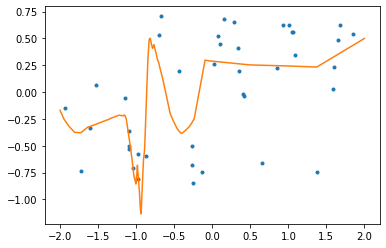

In [337]:

n_data=41
# hidden_layers=[16,32,256,32,16]
hidden_layers=[128,128,256,128]
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*8)+np.random.randn(x.shape[0],x.shape[1])*0.1
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
for ii in range(1):
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=1,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=True,passes=100,total_info=10,failed_attempts=10)
    plt.plot(x_test,net.forward(x_test)[0])

In [290]:
y.shape,x.shape

((401, 1), (401, 1))

In [462]:
np.random.randn(3,1)

array([[-0.02357909],
       [-0.61785435],
       [ 1.9961463 ]])

In [238]:
def test_fun_2d(x):
    y=0.8*np.cos(np.sqrt(x[:,0]**2+x[:,1]**2)*5)
#     y=0.8*np.cos(x[:,0]*5)

    y=y.reshape((y.shape[0],1))+np.random.randn(y.shape[0],1)*0.1

    return y

In [229]:
aa=np.random.randn(3,4)
np.eye(aa.shape)

TypeError: 'tuple' object cannot be interpreted as an integer

In [307]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
hidden_layers=[128,128,128]
hidden_layers=[32,256,256,32]
hidden_layers=[32,128,128,32]

n1=int(np.sqrt(n_data))
# x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
# x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
# plt.plot(x,y,'.')
for ii in range(1):
    net=BNet7(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,lambda_initaliser=lambda_initaliser,initialiser_function=initialiser_function)
    net.train(x,y,print_error=True,passes=5,total_info=1,failed_attempts=10)
#     plt.plot(x_test,net.forward(x_test)[0])

0: Error1: 0.34377172600978256, Error2: 0.002849271278385114 
Total fails (no activations): 0
1: Error1: 4.1344713561323605, Error2: 0.011793212857782457 
Total fails (no activations): 0
2: Error1: 1.7525551553334664, Error2: 0.0006934365800529631 
Total fails (no activations): 0
3: Error1: 0.02343273472001018, Error2: 0.00012101016137696405 
Total fails (no activations): 0
4: Error1: 0.22624775269942052, Error2: 0.012125184687418683 
Total fails (no activations): 0
5: Error1: 0.513741908800219, Error2: 0.0195237865127899 
Total fails (no activations): 0
6: Error1: 1.3236685801390842, Error2: 0.05687640081688327 
Total fails (no activations): 0
7: Error1: 0.0030649129362367387, Error2: 0.00015476650155263599 
Total fails (no activations): 0
8: Error1: 0.02263404475406241, Error2: 0.0013565273310484826 
Total fails (no activations): 0
9: Error1: 0.0661775313952805, Error2: 0.0009314784116860221 
Total fails (no activations): 0
10: Error1: 0.025088462099334123, Error2: 0.0010829672947546

88: Error1: 0.35011341240600374, Error2: 0.17445816401570072 
Total fails (no activations): 0
89: Error1: 0.018453212438749263, Error2: 0.009724857727081267 
Total fails (no activations): 0
90: Error1: 0.36644526289906043, Error2: 0.09991041121561053 
Total fails (no activations): 0
91: Error1: 0.4897244387407445, Error2: 0.11418116471262624 
Total fails (no activations): 0
92: Error1: 0.5390107015956761, Error2: 0.3194209584968909 
Total fails (no activations): 0
93: Error1: 8.056526163055123e-05, Error2: 5.0901550790986624e-05 
Total fails (no activations): 0
94: Error1: 0.2186229815684212, Error2: 0.12743904712201617 
Total fails (no activations): 0
95: Error1: 0.00010244002512691792, Error2: 7.327223542804397e-06 
Total fails (no activations): 0
96: Error1: 0.05127837455123789, Error2: 0.009278977782256377 
Total fails (no activations): 0
97: Error1: 0.03755392883397322, Error2: 0.02113632766375733 
Total fails (no activations): 0
98: Error1: 0.5946418666084858, Error2: 0.193780298

175: Error1: 0.11816537044308016, Error2: 0.07824126062419931 
Total fails (no activations): 0
176: Error1: 0.410132453779892, Error2: 0.2790944759047768 
Total fails (no activations): 0
177: Error1: 0.13093828014696174, Error2: 0.10032198232836842 
Total fails (no activations): 0
178: Error1: 0.004004925882045891, Error2: 0.002445096332877895 
Total fails (no activations): 0
179: Error1: 0.289304336922068, Error2: 0.1924476009644491 
Total fails (no activations): 0
180: Error1: 0.4658683055759157, Error2: 0.20337842539535034 
Total fails (no activations): 0
181: Error1: 0.11776972679290267, Error2: 0.08000894475915618 
Total fails (no activations): 0
182: Error1: 0.008550301115208232, Error2: 0.006182828187719117 
Total fails (no activations): 0
183: Error1: 0.03586414127323308, Error2: 0.02400557907394608 
Total fails (no activations): 0
184: Error1: 0.07196275140606498, Error2: 0.05423448993973042 
Total fails (no activations): 0
185: Error1: 0.0776196637234032, Error2: 0.0588907930

262: Error1: 0.07178234401064647, Error2: 0.05987960407549898 
Total fails (no activations): 0
263: Error1: 0.016544396076382986, Error2: 0.012403040056079017 
Total fails (no activations): 0
264: Error1: 0.7379250935899158, Error2: 0.4497535398991689 
Total fails (no activations): 0
265: Error1: 0.2569071784911345, Error2: 0.22624736094593717 
Total fails (no activations): 0
266: Error1: 0.32151859201685806, Error2: 0.2797411274067261 
Total fails (no activations): 0
267: Error1: 0.00014594848127134376, Error2: 1.264456164480894e-06 
Total fails (no activations): 0
268: Error1: 0.25763594681747365, Error2: 0.19188934630059257 
Total fails (no activations): 0
269: Error1: 1.0232108789221819, Error2: 0.6649458141801727 
Total fails (no activations): 0
270: Error1: 0.3173479865481739, Error2: 0.22760106914211334 
Total fails (no activations): 0
271: Error1: 0.260712566929328, Error2: 0.2208909826414664 
Total fails (no activations): 0
272: Error1: 0.4849442345034598, Error2: 0.4350908621

349: Error1: 0.0532063016927389, Error2: 0.04303761978022049 
Total fails (no activations): 0
350: Error1: 0.0039377767197370985, Error2: 0.002858395253711714 
Total fails (no activations): 0
351: Error1: 0.07374481483409968, Error2: 0.052425707244838214 
Total fails (no activations): 0
352: Error1: 0.023863280034626892, Error2: 0.017211652759446222 
Total fails (no activations): 0
353: Error1: 0.07846638002474547, Error2: 0.04376702202346139 
Total fails (no activations): 0
354: Error1: 0.18654564535219564, Error2: 0.1291288344123543 
Total fails (no activations): 0
355: Error1: 0.0004244446098405658, Error2: 0.0003849700351011804 
Total fails (no activations): 0
356: Error1: 0.1983161293563136, Error2: 0.15416636553502752 
Total fails (no activations): 0
357: Error1: 0.006010165483501187, Error2: 0.0023487278358664994 
Total fails (no activations): 0
358: Error1: 0.00563484755930754, Error2: 0.0035732352041307944 
Total fails (no activations): 0
359: Error1: 0.01988785893262623, Erro

436: Error1: 0.010864443611343174, Error2: 0.00908262583592989 
Total fails (no activations): 1
437: Error1: 0.36455023385622204, Error2: 0.29611222522549274 
Total fails (no activations): 1
438: Error1: 0.38476835749709215, Error2: 0.2667592817350654 
Total fails (no activations): 1
439: Error1: 0.004747801909903316, Error2: 0.004267265264900825 
Total fails (no activations): 1
440: Error1: 0.019509546279804675, Error2: 0.016725670360883623 
Total fails (no activations): 1
441: Error1: 0.011641119464278208, Error2: 0.009781268176275667 
Total fails (no activations): 1
442: Error1: 0.0032906722759107362, Error2: 0.002842124458559686 
Total fails (no activations): 1
443: Error1: 0.2188260081256589, Error2: 0.18478488680647315 
Total fails (no activations): 1
444: Error1: 0.5038010649602018, Error2: 0.38878614542574974 
Total fails (no activations): 1
445: Error1: 0.25678286417412527, Error2: 0.19654029403335 
Total fails (no activations): 1
446: Error1: 0.1328048710477251, Error2: 0.102

523: Error1: 0.13095703171702489, Error2: 0.10192418292839986 
Total fails (no activations): 4
524: Error1: 0.36633418436998183, Error2: 0.2935553267295105 
Total fails (no activations): 4
525: Error1: 0.06593693198101758, Error2: 0.048239469761028345 
Total fails (no activations): 4
526: Error1: 0.0028170111344481196, Error2: 0.0019044477046022417 
Total fails (no activations): 4
527: Error1: 0.03671010730239931, Error2: 0.03139254752874479 
Total fails (no activations): 4
528: Error1: 0.6454809702118988, Error2: 0.48387119088626557 
Total fails (no activations): 4
529: Error1: 0.2076793723520324, Error2: 0.14380439877968815 
Total fails (no activations): 4
530: Error1: 1.3039044827258046, Error2: 0.947646749275873 
Total fails (no activations): 4
531: Error1: 0.04010793980122979, Error2: 0.031833237846159275 
Total fails (no activations): 4
532: Error1: 0.2207237094230283, Error2: 0.12733877534497146 
Total fails (no activations): 4
533: Error1: 0.01437946390590018, Error2: 0.0096738

610: Error1: 0.02640815409490463, Error2: 0.02462732620429906 
Total fails (no activations): 7
611: Error1: 0.02197143195546419, Error2: 0.01721200067273645 
Total fails (no activations): 7
612: Error1: 0.002798771946913725, Error2: 0.0023364429477893537 
Total fails (no activations): 7
613: Error1: 0.07464201873695421, Error2: 0.06382169283763872 
Total fails (no activations): 7
614: Error1: 0.054221081205742795, Error2: 0.044594773066469064 
Total fails (no activations): 7
615: Error1: 0.22546583376252435, Error2: 0.18674445629319775 
Total fails (no activations): 7
616: Error1: 0.19512729348552382, Error2: 0.11261585569406335 
Total fails (no activations): 7
617: Error1: 0.32653675515247954, Error2: 0.2634798598840446 
Total fails (no activations): 7
618: Error1: 0.020577478634878337, Error2: 0.019278601596475625 
Total fails (no activations): 7
619: Error1: 0.3813196891588003, Error2: 0.30026976401721833 
Total fails (no activations): 7
620: Error1: 0.3837899314457429, Error2: 0.33

696: Error1: 0.09739360515055111, Error2: 0.09000216069927723 
Total fails (no activations): 10
697: Error1: 0.006424787912245303, Error2: 0.004859818803262443 
Total fails (no activations): 10
698: Error1: 0.013792857993177246, Error2: 0.00992216209987274 
Total fails (no activations): 10
699: Error1: 0.16978466923074306, Error2: 0.14229522308103956 
Total fails (no activations): 10
700: Error1: 0.0002958007348997256, Error2: 0.00043839751820843475 
Total fails (no activations): 10
701: Error1: 0.060037636113454515, Error2: 0.053966655430289126 
Total fails (no activations): 10
702: Error1: 0.10200928120771484, Error2: 0.08456420498902113 
Total fails (no activations): 10
703: Error1: 1.3686457699024056e-06, Error2: 1.0204081648135542e-06 
Total fails (no activations): 10
704: Error1: 0.05997386277238798, Error2: 0.05505240367929818 
Total fails (no activations): 10
705: Error1: 0.45751246846913046, Error2: 0.4084449350007102 
Total fails (no activations): 10
706: Error1: 0.0001369123

781: Error1: 0.7826732703123065, Error2: 0.7826732703123065 
Total fails (no activations): 15
782: Error1: 0.17923147486282623, Error2: 0.16067404036010965 
Total fails (no activations): 15
783: Error1: 0.19374634960009424, Error2: 0.1668471340629066 
Total fails (no activations): 15
784: Error1: 0.3232984273846003, Error2: 0.2504448740613765 
Total fails (no activations): 15
785: Error1: 0.008291934135325847, Error2: 0.006155795156026278 
Total fails (no activations): 15
786: Error1: 0.4846992887878934, Error2: 0.4846992887878934 
Total fails (no activations): 16
787: Error1: 0.20776279055003136, Error2: 0.13870248433122184 
Total fails (no activations): 16
788: Error1: 0.306308727280474, Error2: 0.2853452353384455 
Total fails (no activations): 16
789: Error1: 0.3279876860460482, Error2: 0.26864425147790055 
Total fails (no activations): 16
790: Error1: 0.1661547126509385, Error2: 0.1400463471680345 
Total fails (no activations): 16
791: Error1: 0.09057430759951804, Error2: 0.0758706

867: Error1: 0.04350707761621209, Error2: 0.02894132537981884 
Total fails (no activations): 19
868: Error1: 0.08089630658951102, Error2: 0.05955883840227076 
Total fails (no activations): 19
869: Error1: 0.46661583828303255, Error2: 0.4334216502408873 
Total fails (no activations): 19
870: Error1: 0.05292691065650893, Error2: 0.04107187676301974 
Total fails (no activations): 19
871: Error1: 0.10317403509146793, Error2: 0.042975548829446465 
Total fails (no activations): 19
872: Error1: 0.008789418748205203, Error2: 0.008209938826473237 
Total fails (no activations): 19
873: Error1: 0.06663786147219902, Error2: 0.06181541548592079 
Total fails (no activations): 19
874: Error1: 0.039960074198157, Error2: 0.03350325956672236 
Total fails (no activations): 19
875: Error1: 0.4536639790356492, Error2: 0.32943434237753916 
Total fails (no activations): 19
876: Error1: 0.3896308726720001, Error2: 0.36669163477271355 
Total fails (no activations): 19
877: Error1: 0.1593328742803397, Error2: 0

952: Error1: 0.7382109106181836, Error2: 0.6208034169807581 
Total fails (no activations): 24
953: Error1: 0.023004235566201625, Error2: 0.02010960831261332 
Total fails (no activations): 24
954: Error1: 0.009661205194332412, Error2: 0.008352990700125584 
Total fails (no activations): 24
955: Error1: 0.2343502632255652, Error2: 0.18728027844879527 
Total fails (no activations): 24
956: Error1: 0.03314805058186905, Error2: 0.026257451149477307 
Total fails (no activations): 24
957: Error1: 0.3833890693372683, Error2: 0.33134812062621016 
Total fails (no activations): 24
958: Error1: 0.03464704675800774, Error2: 0.030963387929157246 
Total fails (no activations): 24
959: Error1: 0.3089093472508801, Error2: 0.283566738403311 
Total fails (no activations): 24
960: Error1: 0.14388061993116713, Error2: 0.11624755631582757 
Total fails (no activations): 24
961: Error1: 0.06678885555197536, Error2: 0.05445016464711224 
Total fails (no activations): 24
962: Error1: 0.02806202737101978, Error2: 

37: Error1: 0.014972816770625664, Error2: 0.01057713962465386 
Total fails (no activations): 29
38: Error1: 0.09437723803585879, Error2: 0.08200527142431444 
Total fails (no activations): 29
39: Error1: 0.097710956682393, Error2: 0.08591939739427418 
Total fails (no activations): 29
40: Error1: 0.21115180217173884, Error2: 0.1858155044249621 
Total fails (no activations): 29
41: Error1: 0.015660532504823826, Error2: 0.012544944609549767 
Total fails (no activations): 29
42: Error1: 0.28626721750182776, Error2: 0.24473394930668627 
Total fails (no activations): 29
43: Error1: 0.3048998822289746, Error2: 0.2745948066784944 
Total fails (no activations): 29
44: Error1: 0.2437834603687684, Error2: 0.22362476558974423 
Total fails (no activations): 29
45: Error1: 0.04799010241551763, Error2: 0.04291557514076528 
Total fails (no activations): 29
46: Error1: 0.06645988361829487, Error2: 0.058121493433018326 
Total fails (no activations): 29
47: Error1: 0.03531987060730269, Error2: 0.032285877

123: Error1: 0.03252482031306972, Error2: 0.029186909041662566 
Total fails (no activations): 31
124: Error1: 0.1620238392780487, Error2: 0.14577391208115026 
Total fails (no activations): 31
125: Error1: 0.021690708455681548, Error2: 0.018791639930907208 
Total fails (no activations): 31
126: Error1: 0.001784542616019133, Error2: 0.0014623586365762574 
Total fails (no activations): 31
127: Error1: 0.03696036244277423, Error2: 0.030738965646212035 
Total fails (no activations): 31
128: Error1: 0.08768457400805545, Error2: 0.07564664760738998 
Total fails (no activations): 31
129: Error1: 0.40199813541058793, Error2: 0.3532773244569978 
Total fails (no activations): 31
130: Error1: 0.10302442651935872, Error2: 0.08642090222250245 
Total fails (no activations): 31
131: Error1: 0.10283713116228183, Error2: 0.09213052140725965 
Total fails (no activations): 31
132: Error1: 0.020588754482437282, Error2: 0.017810437067580676 
Total fails (no activations): 31
133: Error1: 0.15037176334201138,

209: Error1: 0.008342837227422595, Error2: 0.007222877687433052 
Total fails (no activations): 37
210: Error1: 0.0006628783938671867, Error2: 0.0005712376037283681 
Total fails (no activations): 37
211: Error1: 0.03187204114604027, Error2: 0.02847337083123246 
Total fails (no activations): 37
212: Error1: 0.013892491761128414, Error2: 0.012664938607170101 
Total fails (no activations): 37
213: Error1: 0.021314381771192454, Error2: 0.018028230862256536 
Total fails (no activations): 37
214: Error1: 0.0473303016225136, Error2: 0.03606486597667111 
Total fails (no activations): 37
215: Error1: 0.0624352893669148, Error2: 0.05794070192918262 
Total fails (no activations): 37
216: Error1: 1.277224540099503e-07, Error2: 1.6160504069395597e-07 
Total fails (no activations): 37
217: Error1: 0.5482343705384628, Error2: 0.4673238570954023 
Total fails (no activations): 37
218: Error1: 0.009043720459728809, Error2: 0.008126537619318079 
Total fails (no activations): 37
219: Error1: 0.493550939250

295: Error1: 0.10772662107675667, Error2: 0.10772662107675667 
Total fails (no activations): 46
296: Error1: 0.0016999355342384374, Error2: 0.001545270484247592 
Total fails (no activations): 46
297: Error1: 0.10201555777398673, Error2: 0.09208243168632742 
Total fails (no activations): 46
298: Error1: 0.004090575375197592, Error2: 0.0035703549167606947 
Total fails (no activations): 46
299: Error1: 0.14302624156099145, Error2: 0.13217945933102596 
Total fails (no activations): 46
300: Error1: 0.047164500548297246, Error2: 0.04295277382401005 
Total fails (no activations): 46
301: Error1: 0.024275076995690505, Error2: 0.022372071528840697 
Total fails (no activations): 46
302: Error1: 0.07029923529198435, Error2: 0.05770725082673092 
Total fails (no activations): 46
303: Error1: 0.06070638155179399, Error2: 0.05143544534795778 
Total fails (no activations): 46
304: Error1: 0.44911024257600723, Error2: 0.4186593478202421 
Total fails (no activations): 46
305: Error1: 0.04999774649857028

380: Error1: 0.056180396870784015, Error2: 0.0544779496285481 
Total fails (no activations): 50
381: Error1: 0.0680828571110892, Error2: 0.06000252666100174 
Total fails (no activations): 50
382: Error1: 0.01716335989921939, Error2: 0.015004466622195114 
Total fails (no activations): 50
383: Error1: 0.08603834674639421, Error2: 0.07334801667174365 
Total fails (no activations): 50
384: Error1: 0.0011417927140180838, Error2: 0.0010721500487811367 
Total fails (no activations): 50
385: Error1: 0.22917798168728318, Error2: 0.2213009483381005 
Total fails (no activations): 50
386: Error1: 0.003560273409572081, Error2: 0.003295998047980758 
Total fails (no activations): 50
387: Error1: 0.3233022404990363, Error2: 0.25882618085800235 
Total fails (no activations): 50
388: Error1: 0.16752835381873551, Error2: 0.15971074638650407 
Total fails (no activations): 50
389: Error1: 4.029686503594141e-05, Error2: 3.4093565715331324e-05 
Total fails (no activations): 50
390: Error1: 0.0920629412981904

465: Error1: 0.47744598656530407, Error2: 0.46565030139444075 
Total fails (no activations): 54
466: Error1: 0.13979492118743278, Error2: 0.13547497808250702 
Total fails (no activations): 54
467: Error1: 0.24273335504187166, Error2: 0.22468723789678852 
Total fails (no activations): 54
468: Error1: 0.05890357935919893, Error2: 0.05598655210264896 
Total fails (no activations): 54
469: Error1: 0.012356571605180224, Error2: 0.011675264317829758 
Total fails (no activations): 54
470: Error1: 0.09336958336105565, Error2: 0.06714957903306772 
Total fails (no activations): 54
471: Error1: 0.015026982069129351, Error2: 0.012933756835431487 
Total fails (no activations): 54
472: Error1: 0.1703014294791584, Error2: 0.14683275637079896 
Total fails (no activations): 54
473: Error1: 0.2832998350017599, Error2: 0.27522021715954276 
Total fails (no activations): 54
474: Error1: 0.03327212966436575, Error2: 0.029381597949743415 
Total fails (no activations): 54
475: Error1: 0.0018808580441117358, E

551: Error1: 1.8824697827460548e-05, Error2: 1.097320596194355e-05 
Total fails (no activations): 57
552: Error1: 0.12584745318723004, Error2: 0.11339082008211131 
Total fails (no activations): 57
553: Error1: 0.020716580087750767, Error2: 0.01850963945452445 
Total fails (no activations): 57
554: Error1: 0.022853749684825484, Error2: 0.020648625174889 
Total fails (no activations): 57
555: Error1: 0.6435986720190151, Error2: 0.6435986720190151 
Total fails (no activations): 58
556: Error1: 0.07103421314441995, Error2: 0.06555500975647303 
Total fails (no activations): 58
557: Error1: 0.0027278285383025903, Error2: 0.002514321884046771 
Total fails (no activations): 58
558: Error1: 0.07665400657204252, Error2: 0.0713570894963219 
Total fails (no activations): 58
559: Error1: 0.19058067230089173, Error2: 0.17987263056052896 
Total fails (no activations): 58
560: Error1: 0.23458844514782234, Error2: 0.22212381681305965 
Total fails (no activations): 58
561: Error1: 0.6171052716338374, Er

636: Error1: 0.0003871663181112752, Error2: 0.0004022072399597197 
Total fails (no activations): 62
637: Error1: 0.27055755142722054, Error2: 0.25414012487405957 
Total fails (no activations): 62
638: Error1: 0.09078577170922081, Error2: 0.08672125864626337 
Total fails (no activations): 62
639: Error1: 0.002543066992811645, Error2: 0.0023473423255441763 
Total fails (no activations): 62
640: Error1: 0.01526668105663904, Error2: 0.014910873772707058 
Total fails (no activations): 62
641: Error1: 0.03916805116621457, Error2: 0.036214176190003625 
Total fails (no activations): 62
642: Error1: 0.2324743046843158, Error2: 0.2271476513025211 
Total fails (no activations): 62
643: Error1: 0.35254977227235645, Error2: 0.29984899671574144 
Total fails (no activations): 62
644: Error1: 0.1984037814252783, Error2: 0.18101467501800603 
Total fails (no activations): 62
645: Error1: 0.3310908740223147, Error2: 0.31849982769789875 
Total fails (no activations): 62
646: Error1: 7.509071981525597e-05,

Total fails (no activations): 65
721: Error1: 0.03666370872811028, Error2: 0.03353327351415513 
Total fails (no activations): 65
722: Error1: 0.007270342961358801, Error2: 0.007091545361473651 
Total fails (no activations): 65
723: Error1: 0.45556441315051593, Error2: 0.44451257068742267 
Total fails (no activations): 65
724: Error1: 0.1445952649823357, Error2: 0.1372135922516687 
Total fails (no activations): 65
725: Error1: 0.03308473204473674, Error2: 0.031106231804007907 
Total fails (no activations): 65
726: Error1: 0.017388254164164174, Error2: 0.016678098769362083 
Total fails (no activations): 65
727: Error1: 0.4698813131551572, Error2: 0.45592566514127375 
Total fails (no activations): 65
728: Error1: 0.12298989461291612, Error2: 0.11037229768471932 
Total fails (no activations): 65
729: Error1: 0.18919899258724032, Error2: 0.16756138370504675 
Total fails (no activations): 65
730: Error1: 0.019067914783275214, Error2: 0.01797173926579298 
Total fails (no activations): 65
731:

806: Error1: 0.0017980015163844407, Error2: 0.0016145598058117296 
Total fails (no activations): 71
807: Error1: 0.0053703180600889605, Error2: 0.0046868820176312566 
Total fails (no activations): 71
808: Error1: 0.2224970285642059, Error2: 0.18038835240255588 
Total fails (no activations): 71
809: Error1: 0.0371051075884999, Error2: 0.03468834627969749 
Total fails (no activations): 71
810: Error1: 0.013300360915856357, Error2: 0.01255853778781994 
Total fails (no activations): 71
811: Error1: 0.4500322388294438, Error2: 0.41733644165062433 
Total fails (no activations): 71
812: Error1: 0.26339709444923537, Error2: 0.24197438639907184 
Total fails (no activations): 71
813: Error1: 2.8396819548090864e-06, Error2: 8.687482765625399e-06 
Total fails (no activations): 71
814: Error1: 0.46393528226332337, Error2: 0.46393528226332337 
Total fails (no activations): 72
815: Error1: 0.04649467253531808, Error2: 0.04351593809950115 
Total fails (no activations): 72
816: Error1: 0.08418520042104

891: Error1: 0.07971688752776142, Error2: 0.07713408764778233 
Total fails (no activations): 77
892: Error1: 0.05745854571895555, Error2: 0.050475652802317715 
Total fails (no activations): 77
893: Error1: 0.1873628638415299, Error2: 0.18140335349761613 
Total fails (no activations): 77
894: Error1: 0.06705533588958874, Error2: 0.06059493952624035 
Total fails (no activations): 77
895: Error1: 0.1052561125532166, Error2: 0.07817189862413325 
Total fails (no activations): 77
896: Error1: 0.0010272159402858708, Error2: 0.0009614542427031171 
Total fails (no activations): 77
897: Error1: 0.3510287094744814, Error2: 0.34239747202429344 
Total fails (no activations): 77
898: Error1: 0.03236671567011567, Error2: 0.029758536324575268 
Total fails (no activations): 77
899: Error1: 0.08042623744037294, Error2: 0.06751525234467134 
Total fails (no activations): 77
900: Error1: 0.024805612977080185, Error2: 0.024805612977080185 
Total fails (no activations): 78
901: Error1: 0.0009985791910226071,

976: Error1: 0.2644309745846222, Error2: 0.24015036230456707 
Total fails (no activations): 82
977: Error1: 0.008662797101848651, Error2: 0.008312994510463651 
Total fails (no activations): 82
978: Error1: 0.09248717531529768, Error2: 0.08760527437302608 
Total fails (no activations): 82
979: Error1: 0.012375353429958005, Error2: 0.012123840034758401 
Total fails (no activations): 82
980: Error1: 5.710653018695194e-06, Error2: 0.00013765843881845757 
Total fails (no activations): 82
981: Error1: 0.00455573115005875, Error2: 0.004118333562236998 
Total fails (no activations): 82
982: Error1: 0.13372653086397676, Error2: 0.1256647796631593 
Total fails (no activations): 82
983: Error1: 0.011590952717591887, Error2: 0.010623503244164815 
Total fails (no activations): 82
984: Error1: 0.4866241390340517, Error2: 0.4866241390340517 
Total fails (no activations): 83
985: Error1: 0.2708234561469155, Error2: 0.2574571026171887 
Total fails (no activations): 83
986: Error1: 0.07267319650265829, 

61: Error1: 0.006447623390520334, Error2: 0.005958214818850725 
Total fails (no activations): 88
62: Error1: 0.031665914277172524, Error2: 0.03023957879575381 
Total fails (no activations): 88
63: Error1: 0.2742325357906252, Error2: 0.25080546243279284 
Total fails (no activations): 88
64: Error1: 0.08856011695907161, Error2: 0.08454122700595063 
Total fails (no activations): 88
65: Error1: 0.1299517558971686, Error2: 0.11669851773935849 
Total fails (no activations): 88
66: Error1: 0.041305044033571846, Error2: 0.03868565336203461 
Total fails (no activations): 88
67: Error1: 0.004133971967020002, Error2: 0.0038022887960526054 
Total fails (no activations): 88
68: Error1: 0.027577358132036104, Error2: 0.026448963591801104 
Total fails (no activations): 88
69: Error1: 0.04660624989199374, Error2: 0.04185754209667219 
Total fails (no activations): 88
70: Error1: 0.07002951604713044, Error2: 0.0654730453425996 
Total fails (no activations): 88
71: Error1: 0.005751674590155551, Error2: 0.

147: Error1: 0.024898460238780284, Error2: 0.024012529155292926 
Total fails (no activations): 91
148: Error1: 0.08356690743241037, Error2: 0.08222922660939014 
Total fails (no activations): 91
149: Error1: 0.006682833066534904, Error2: 0.006357382193723851 
Total fails (no activations): 91
150: Error1: 0.46850304952163335, Error2: 0.44139757309806815 
Total fails (no activations): 91
151: Error1: 0.1342138158256861, Error2: 0.12511335113792005 
Total fails (no activations): 91
152: Error1: 0.00016988994304310874, Error2: 0.00016670309648306452 
Total fails (no activations): 91
153: Error1: 0.00010025171837813145, Error2: 0.00014995049719190997 
Total fails (no activations): 91
154: Error1: 0.21858174453797008, Error2: 0.20770438475944525 
Total fails (no activations): 91
155: Error1: 0.003157091167299185, Error2: 0.0030058844470852684 
Total fails (no activations): 91
156: Error1: 0.030374786312235398, Error2: 0.029220204403550387 
Total fails (no activations): 91
157: Error1: 0.00354

232: Error1: 0.08342171678362528, Error2: 0.0805755401237021 
Total fails (no activations): 96
233: Error1: 0.08933085609449311, Error2: 0.08790637830581166 
Total fails (no activations): 96
234: Error1: 0.000964798641995073, Error2: 0.0009888500857835512 
Total fails (no activations): 96
235: Error1: 0.01462907447627999, Error2: 0.013856485350576606 
Total fails (no activations): 96
236: Error1: 5.524958024208048e-05, Error2: 4.481635368459224e-05 
Total fails (no activations): 96
237: Error1: 5.776447226479e-07, Error2: 6.863396145488067e-07 
Total fails (no activations): 96
238: Error1: 0.28465327757089387, Error2: 0.26352705594342285 
Total fails (no activations): 96
239: Error1: 0.023958991056662413, Error2: 0.020406689584556128 
Total fails (no activations): 96
240: Error1: 0.004338563739476242, Error2: 0.004086822144351944 
Total fails (no activations): 96
241: Error1: 0.03608171537666519, Error2: 0.03388037989579407 
Total fails (no activations): 96
242: Error1: 0.2560145921285

317: Error1: 0.07890052636117409, Error2: 0.07326583029509 
Total fails (no activations): 104
318: Error1: 0.05748832808051712, Error2: 0.05215739361222666 
Total fails (no activations): 104
319: Error1: 0.055625158359638424, Error2: 0.0520940720032089 
Total fails (no activations): 104
320: Error1: 0.08001894611669608, Error2: 0.07540884265407813 
Total fails (no activations): 104
321: Error1: 0.03131155737186858, Error2: 0.028952532377648874 
Total fails (no activations): 104
322: Error1: 0.008070257285196522, Error2: 0.007504194908071249 
Total fails (no activations): 104
323: Error1: 0.5206663573156817, Error2: 0.499596741544426 
Total fails (no activations): 104
324: Error1: 0.001669772998453042, Error2: 0.0014752344345778528 
Total fails (no activations): 104
325: Error1: 0.024072468644820096, Error2: 0.02075077574533333 
Total fails (no activations): 104
326: Error1: 0.011367115691151794, Error2: 0.010835639533466754 
Total fails (no activations): 104
327: Error1: 0.013967631631

401: Error1: 7.494483611247703e-05, Error2: 7.54513226542768e-05 
Total fails (no activations): 108
402: Error1: 0.06483678001326813, Error2: 0.061682323843779266 
Total fails (no activations): 108
403: Error1: 0.017393726634645897, Error2: 0.01610299604227926 
Total fails (no activations): 108
404: Error1: 0.16740448803340277, Error2: 0.1550820151195357 
Total fails (no activations): 108
405: Error1: 0.010457173717598025, Error2: 0.009717703987150968 
Total fails (no activations): 108
406: Error1: 0.3845369450748125, Error2: 0.3845369450748125 
Total fails (no activations): 109
407: Error1: 0.00019602922348899255, Error2: 0.00014943217995729339 
Total fails (no activations): 109
408: Error1: 0.0011648275131913965, Error2: 0.0011351756703835275 
Total fails (no activations): 109
409: Error1: 0.0376685540707833, Error2: 0.03635007492544752 
Total fails (no activations): 109
410: Error1: 0.36738843017494605, Error2: 0.36738843017494605 
Total fails (no activations): 110
411: Error1: 0.18

486: Error1: 0.01995592461134219, Error2: 0.018920170900578424 
Total fails (no activations): 114
487: Error1: 0.003296787541722618, Error2: 0.002543849647690659 
Total fails (no activations): 114
488: Error1: 0.17362064722895434, Error2: 0.16473117171597776 
Total fails (no activations): 114
489: Error1: 3.900912383205976e-05, Error2: 3.900912383205976e-05 
Total fails (no activations): 115
490: Error1: 0.019834652860313606, Error2: 0.018604031728987856 
Total fails (no activations): 115
491: Error1: 0.0078106684304104475, Error2: 0.007159993740539882 
Total fails (no activations): 115
492: Error1: 0.09595154706026594, Error2: 0.08963414796385864 
Total fails (no activations): 115
493: Error1: 0.42418800515720356, Error2: 0.42418800515720356 
Total fails (no activations): 116
494: Error1: 0.3833213840333277, Error2: 0.3609583057868526 
Total fails (no activations): 116
495: Error1: 0.03789883172967368, Error2: 0.036129839079905406 
Total fails (no activations): 116
496: Error1: 0.0324

570: Error1: 0.048945075888250526, Error2: 0.046103059256557256 
Total fails (no activations): 117
571: Error1: 0.0023308784516733938, Error2: 0.0021100313240720293 
Total fails (no activations): 117
572: Error1: 0.1472167760635001, Error2: 0.14105388943319677 
Total fails (no activations): 117
573: Error1: 0.12240687125659769, Error2: 0.11512384384080422 
Total fails (no activations): 117
574: Error1: 0.006099320727735849, Error2: 0.005716668992294297 
Total fails (no activations): 117
575: Error1: 0.023223254354448813, Error2: 0.022317476677930635 
Total fails (no activations): 117
576: Error1: 0.30442724311615843, Error2: 0.30442724311615843 
Total fails (no activations): 118
577: Error1: 0.07522291582052257, Error2: 0.0705852817361503 
Total fails (no activations): 118
578: Error1: 0.05770264091024098, Error2: 0.05492515122363855 
Total fails (no activations): 118
579: Error1: 0.01585546062917334, Error2: 0.015198047143470395 
Total fails (no activations): 118
580: Error1: 0.111469

Total fails (no activations): 121
654: Error1: 0.42374911132085225, Error2: 0.4030110356523267 
Total fails (no activations): 121
655: Error1: 0.03664343758697815, Error2: 0.0326504245178628 
Total fails (no activations): 121
656: Error1: 0.2839629782553951, Error2: 0.2713265927591143 
Total fails (no activations): 121
657: Error1: 0.0796797963859099, Error2: 0.0734451179812478 
Total fails (no activations): 121
658: Error1: 0.15166799795575658, Error2: 0.14581758732964734 
Total fails (no activations): 121
659: Error1: 0.005196116708688588, Error2: 0.0043085347158622845 
Total fails (no activations): 121
660: Error1: 0.12201835274656873, Error2: 0.11801560406118293 
Total fails (no activations): 121
661: Error1: 0.001367474167568807, Error2: 0.0011881878333553774 
Total fails (no activations): 121
662: Error1: 0.03173041392549313, Error2: 0.03020144685576938 
Total fails (no activations): 121
663: Error1: 0.054596144702332185, Error2: 0.0516003798201443 
Total fails (no activations): 

738: Error1: 0.025624104663884532, Error2: 0.024165166404733773 
Total fails (no activations): 124
739: Error1: 0.06892454105831072, Error2: 0.06528747325352716 
Total fails (no activations): 124
740: Error1: 0.02032463756574485, Error2: 0.018956817493797108 
Total fails (no activations): 124
741: Error1: 0.014939187105630337, Error2: 0.014143554325693258 
Total fails (no activations): 124
742: Error1: 0.0030744042301536164, Error2: 0.0029529321033148464 
Total fails (no activations): 124
743: Error1: 0.0026628802008133792, Error2: 0.002661847632710099 
Total fails (no activations): 124
744: Error1: 0.001073826102376607, Error2: 0.0009752697346411218 
Total fails (no activations): 124
745: Error1: 0.13511142528498948, Error2: 0.12843804756124008 
Total fails (no activations): 124
746: Error1: 0.004016016294787466, Error2: 0.0035516280150578263 
Total fails (no activations): 124
747: Error1: 0.12166918023794193, Error2: 0.1132117215210595 
Total fails (no activations): 124
748: Error1: 

822: Error1: 0.025264940572849424, Error2: 0.024110952232175378 
Total fails (no activations): 130
823: Error1: 0.016389255896356245, Error2: 0.015495482867312142 
Total fails (no activations): 130
824: Error1: 0.1968232800384822, Error2: 0.1889238557084233 
Total fails (no activations): 130
825: Error1: 0.28203618468554476, Error2: 0.2773175082481952 
Total fails (no activations): 130
826: Error1: 0.11280048433543668, Error2: 0.10220931712995791 
Total fails (no activations): 130
827: Error1: 0.021238363991684835, Error2: 0.01984778480631207 
Total fails (no activations): 130
828: Error1: 0.029664794810680756, Error2: 0.028637755765892767 
Total fails (no activations): 130
829: Error1: 0.03948207162238404, Error2: 0.03318878076090404 
Total fails (no activations): 130
830: Error1: 0.04140017828885522, Error2: 0.040602166589466686 
Total fails (no activations): 130
831: Error1: 0.03971805374032845, Error2: 0.03912167687071029 
Total fails (no activations): 130
832: Error1: 0.2596195882

906: Error1: 0.19296324817695104, Error2: 0.18619891876508454 
Total fails (no activations): 134
907: Error1: 0.03467895804657154, Error2: 0.03331826796569616 
Total fails (no activations): 134
908: Error1: 0.14435957288511184, Error2: 0.13252879061024161 
Total fails (no activations): 134
909: Error1: 0.07741813203734169, Error2: 0.0748734560792408 
Total fails (no activations): 134
910: Error1: 0.00012626809565606447, Error2: 0.00011087034439182069 
Total fails (no activations): 134
911: Error1: 0.01791891060769406, Error2: 0.015805736209433714 
Total fails (no activations): 134
912: Error1: 0.06989634005712995, Error2: 0.06760093285444568 
Total fails (no activations): 134
913: Error1: 0.0008077069493344546, Error2: 0.0006657760972222041 
Total fails (no activations): 134
914: Error1: 0.05454358272430514, Error2: 0.05285977697616852 
Total fails (no activations): 134
915: Error1: 0.3593998911194301, Error2: 0.3332647024413201 
Total fails (no activations): 134
916: Error1: 0.0538702

990: Error1: 0.07684112495441696, Error2: 0.07283691900257253 
Total fails (no activations): 138
991: Error1: 0.0031054190135761063, Error2: 0.0029474782367170565 
Total fails (no activations): 138
992: Error1: 0.4313746456177249, Error2: 0.4152244944208195 
Total fails (no activations): 138
993: Error1: 0.11758810542352809, Error2: 0.11360851269360844 
Total fails (no activations): 138
994: Error1: 0.6848778380209737, Error2: 0.6467165174433692 
Total fails (no activations): 138
995: Error1: 0.16243066039992832, Error2: 0.1517909057999635 
Total fails (no activations): 138
996: Error1: 0.00046932764562470833, Error2: 0.00036498306337383215 
Total fails (no activations): 138
997: Error1: 0.002571365588829933, Error2: 0.0024484828524002212 
Total fails (no activations): 138
998: Error1: 0.09008614429013481, Error2: 0.08486892366986251 
Total fails (no activations): 138
999: Error1: 0.13220936863263683, Error2: 0.12385749068200955 
Total fails (no activations): 138
1000: Error1: 0.136902

74: Error1: 0.0714643440719055, Error2: 0.06995239290771262 
Total fails (no activations): 142
75: Error1: 0.057436644246595704, Error2: 0.05546021572005422 
Total fails (no activations): 142
76: Error1: 0.16213630129521614, Error2: 0.15255800864213845 
Total fails (no activations): 142
77: Error1: 0.06166643359505752, Error2: 0.05934355456272719 
Total fails (no activations): 142
78: Error1: 0.31764918229658706, Error2: 0.30541710489825885 
Total fails (no activations): 142
79: Error1: 0.09683437629882002, Error2: 0.0928719804863969 
Total fails (no activations): 142
80: Error1: 0.00616121251507686, Error2: 0.0059261901457598205 
Total fails (no activations): 142
81: Error1: 0.09863098718421393, Error2: 0.09397987565154228 
Total fails (no activations): 142
82: Error1: 0.08377267796548324, Error2: 0.07867531417031579 
Total fails (no activations): 142
83: Error1: 0.03808913302784304, Error2: 0.03707354652440121 
Total fails (no activations): 142
84: Error1: 0.05788640254458653, Error2

159: Error1: 0.5321317622967454, Error2: 0.5207837566142949 
Total fails (no activations): 146
160: Error1: 0.3876319571336315, Error2: 0.3876319571336315 
Total fails (no activations): 147
161: Error1: 0.35345186311479193, Error2: 0.3389456630653348 
Total fails (no activations): 147
162: Error1: 0.5032466591211295, Error2: 0.4367317767331502 
Total fails (no activations): 147
163: Error1: 0.1434413612901408, Error2: 0.13707652197594475 
Total fails (no activations): 147
164: Error1: 0.06676990176473105, Error2: 0.06278789410134512 
Total fails (no activations): 147
165: Error1: 0.1270719567107142, Error2: 0.12349926909408106 
Total fails (no activations): 147
166: Error1: 0.08132104488313877, Error2: 0.07806758490461041 
Total fails (no activations): 147
167: Error1: 0.00842750998158068, Error2: 0.008047541974065745 
Total fails (no activations): 147
168: Error1: 0.2662249389214301, Error2: 0.2662249389214301 
Total fails (no activations): 148
169: Error1: 0.028033660724242227, Error

243: Error1: 0.08112598835332246, Error2: 0.07640545696002048 
Total fails (no activations): 152
244: Error1: 0.2717818945617219, Error2: 0.26811359522675493 
Total fails (no activations): 152
245: Error1: 0.020643614509178444, Error2: 0.020643614509178444 
Total fails (no activations): 153
246: Error1: 0.18272329346414054, Error2: 0.1663183507303395 
Total fails (no activations): 153
247: Error1: 3.1820484819921168e-06, Error2: 2.977502310880048e-06 
Total fails (no activations): 153
248: Error1: 0.08106813747977773, Error2: 0.07787616234049559 
Total fails (no activations): 153
249: Error1: 0.00656332865688249, Error2: 0.006338059707824542 
Total fails (no activations): 153
250: Error1: 0.003864156167197943, Error2: 0.0038364669078205377 
Total fails (no activations): 153
251: Error1: 0.5526175040220621, Error2: 0.5526175040220621 
Total fails (no activations): 154
252: Error1: 0.012820923537753423, Error2: 0.01206272926047384 
Total fails (no activations): 154
253: Error1: 0.6532389

327: Error1: 0.0205101860823342, Error2: 0.019384068927433308 
Total fails (no activations): 158
328: Error1: 0.012175933502509369, Error2: 0.011599677819928718 
Total fails (no activations): 158
329: Error1: 0.5493520809593807, Error2: 0.5493520809593807 
Total fails (no activations): 159
330: Error1: 0.0190607872657638, Error2: 0.017751806403856065 
Total fails (no activations): 159
331: Error1: 0.49840018836189653, Error2: 0.49840018836189653 
Total fails (no activations): 160
332: Error1: 0.0016272204406872083, Error2: 0.0014919550184757538 
Total fails (no activations): 160
333: Error1: 0.026338722322035484, Error2: 0.025175391419207684 
Total fails (no activations): 160
334: Error1: 0.002787463667088756, Error2: 0.002701778979582908 
Total fails (no activations): 160
335: Error1: 0.0566009184015571, Error2: 0.053334880343089065 
Total fails (no activations): 160
336: Error1: 0.05102331818717107, Error2: 0.04835614652056058 
Total fails (no activations): 160
337: Error1: 0.0578954

411: Error1: 0.1698001932338517, Error2: 0.16474207384562478 
Total fails (no activations): 163
412: Error1: 0.22143613891818914, Error2: 0.21001140420226097 
Total fails (no activations): 163
413: Error1: 0.0021996596064400766, Error2: 0.0021055532388537007 
Total fails (no activations): 163
414: Error1: 0.4638869248999651, Error2: 0.4638869248999651 
Total fails (no activations): 164
415: Error1: 0.18630554030729124, Error2: 0.1838019563391314 
Total fails (no activations): 164
416: Error1: 0.012946527299305646, Error2: 0.012285549398359116 
Total fails (no activations): 164
417: Error1: 0.11393587149871394, Error2: 0.10989324255932534 
Total fails (no activations): 164
418: Error1: 0.5074353954134243, Error2: 0.48292045891814434 
Total fails (no activations): 164
419: Error1: 0.03872563746046702, Error2: 0.034725660726787816 
Total fails (no activations): 164
420: Error1: 0.015261707146617572, Error2: 0.014948296659729106 
Total fails (no activations): 164
421: Error1: 0.12445553377

495: Error1: 0.06756329089412459, Error2: 0.06371513776713654 
Total fails (no activations): 169
496: Error1: 0.03035511105462801, Error2: 0.02912898479805075 
Total fails (no activations): 169
497: Error1: 1.1660913520249153e-05, Error2: 1.0668907837889235e-05 
Total fails (no activations): 169
498: Error1: 0.3004772089185087, Error2: 0.29159695760622945 
Total fails (no activations): 169
499: Error1: 0.10976748960829376, Error2: 0.10463474438926296 
Total fails (no activations): 169
500: Error1: 0.04857894773794568, Error2: 0.04603811060672863 
Total fails (no activations): 169
501: Error1: 0.005151333554692252, Error2: 0.005029863530911692 
Total fails (no activations): 169
502: Error1: 0.002643030649947286, Error2: 0.002526746846767163 
Total fails (no activations): 169
503: Error1: 0.12306870369939199, Error2: 0.11940663106665145 
Total fails (no activations): 169
504: Error1: 0.00820856345859364, Error2: 0.00800217821001095 
Total fails (no activations): 169
505: Error1: 0.043486

579: Error1: 0.005781860224849921, Error2: 0.0056042582157060225 
Total fails (no activations): 171
580: Error1: 0.09391182470628211, Error2: 0.0850405901846649 
Total fails (no activations): 171
581: Error1: 0.012048681784967088, Error2: 0.011672332519218589 
Total fails (no activations): 171
582: Error1: 0.04180204571870885, Error2: 0.04093571345308213 
Total fails (no activations): 171
583: Error1: 0.07254651537388716, Error2: 0.0684332837374294 
Total fails (no activations): 171
584: Error1: 0.001980807905893749, Error2: 0.0018315188960100887 
Total fails (no activations): 171
585: Error1: 0.003962568656027815, Error2: 0.0038556333534245715 
Total fails (no activations): 171
586: Error1: 0.19447321297336312, Error2: 0.19035152299847918 
Total fails (no activations): 171
587: Error1: 0.284730442195365, Error2: 0.2765240679362535 
Total fails (no activations): 171
588: Error1: 0.1546759960319859, Error2: 0.14765707906739534 
Total fails (no activations): 171
589: Error1: 0.0236648108

663: Error1: 0.05251601092915833, Error2: 0.0499960336579888 
Total fails (no activations): 174
664: Error1: 0.07759605116282411, Error2: 0.07471026223867767 
Total fails (no activations): 174
665: Error1: 0.042686524668509786, Error2: 0.041469967239371484 
Total fails (no activations): 174
666: Error1: 0.005193953721199126, Error2: 0.005112255363710506 
Total fails (no activations): 174
667: Error1: 0.08374265103319284, Error2: 0.08132364504054429 
Total fails (no activations): 174
668: Error1: 0.02340447885569673, Error2: 0.022117345648441315 
Total fails (no activations): 174
669: Error1: 0.0418591092255114, Error2: 0.03840972069098856 
Total fails (no activations): 174
670: Error1: 0.10856915509356545, Error2: 0.10319065840210731 
Total fails (no activations): 174
671: Error1: 0.018070836617688494, Error2: 0.017610923985887053 
Total fails (no activations): 174
672: Error1: 0.027792703666720837, Error2: 0.026756312480825807 
Total fails (no activations): 174
673: Error1: 0.01977935

747: Error1: 0.09346647514972523, Error2: 0.08830506177541418 
Total fails (no activations): 177
748: Error1: 0.2077998002510598, Error2: 0.20127777456938795 
Total fails (no activations): 177
749: Error1: 0.027489615311230807, Error2: 0.026754763524024342 
Total fails (no activations): 177
750: Error1: 0.07915141852538421, Error2: 0.07473597238198725 
Total fails (no activations): 177
751: Error1: 0.040435594915243525, Error2: 0.03895145081959376 
Total fails (no activations): 177
752: Error1: 0.0030450021421990175, Error2: 0.002911345805111142 
Total fails (no activations): 177
753: Error1: 0.009786082493880773, Error2: 0.00956227172224344 
Total fails (no activations): 177
754: Error1: 0.007707259702854038, Error2: 0.007475299931352017 
Total fails (no activations): 177
755: Error1: 0.0016248072016467993, Error2: 0.0014949749484194348 
Total fails (no activations): 177
756: Error1: 0.019745313686553127, Error2: 0.018968730370418088 
Total fails (no activations): 177
757: Error1: 0.0

831: Error1: 0.05466503384992951, Error2: 0.054024722365595156 
Total fails (no activations): 182
832: Error1: 0.2868277085464671, Error2: 0.2868277085464671 
Total fails (no activations): 183
833: Error1: 0.044401610711660766, Error2: 0.043669108136769115 
Total fails (no activations): 183
834: Error1: 0.20677526657462944, Error2: 0.19875790378355987 
Total fails (no activations): 183
835: Error1: 0.23489883603819597, Error2: 0.22366710600233647 
Total fails (no activations): 183
836: Error1: 0.17230065129112088, Error2: 0.16186754812215864 
Total fails (no activations): 183
837: Error1: 0.0730821658764909, Error2: 0.07103830906091686 
Total fails (no activations): 183
838: Error1: 0.025626327538788355, Error2: 0.024631615993862935 
Total fails (no activations): 183
839: Error1: 0.15898550213977267, Error2: 0.15212418421874263 
Total fails (no activations): 183
840: Error1: 0.47622598177108894, Error2: 0.4564912392571676 
Total fails (no activations): 183
841: Error1: 0.00691068909195

915: Error1: 0.15084001252167203, Error2: 0.14290771722211976 
Total fails (no activations): 186
916: Error1: 0.07564933417919727, Error2: 0.07227116891480208 
Total fails (no activations): 186
917: Error1: 0.06762110801394046, Error2: 0.059759790452974915 
Total fails (no activations): 186
918: Error1: 0.04303666317211471, Error2: 0.041199500631223795 
Total fails (no activations): 186
919: Error1: 1.8751800717635595e-05, Error2: 2.33033274675868e-05 
Total fails (no activations): 186
920: Error1: 0.14439845059810472, Error2: 0.13971197290073853 
Total fails (no activations): 186
921: Error1: 7.8360547051591e-05, Error2: 7.3713873440931e-05 
Total fails (no activations): 186
922: Error1: 0.07635731647451198, Error2: 0.07339530097589954 
Total fails (no activations): 186
923: Error1: 0.02708942906261618, Error2: 0.02708942906261618 
Total fails (no activations): 187
924: Error1: 0.0018285775358917694, Error2: 0.0016947853566286726 
Total fails (no activations): 187
925: Error1: 0.00042

999: Error1: 0.11476870646356029, Error2: 0.10898207399885888 
Total fails (no activations): 189
1000: Error1: 0.1215244889949901, Error2: 0.11835449819089408 
Total fails (no activations): 189
0: Error1: 0.005006356413148958, Error2: 0.004816436639188551 
Total fails (no activations): 189
1: Error1: 0.0584742504418861, Error2: 0.05589753419125968 
Total fails (no activations): 189
2: Error1: 0.14119261303637004, Error2: 0.13258338732794228 
Total fails (no activations): 189
3: Error1: 0.07713232939254278, Error2: 0.07560472958810106 
Total fails (no activations): 189
4: Error1: 0.04791701386457521, Error2: 0.04619063533370365 
Total fails (no activations): 189
5: Error1: 0.0002031779529590844, Error2: 0.00019929346347034415 
Total fails (no activations): 189
6: Error1: 0.568799277813397, Error2: 0.5595448914940857 
Total fails (no activations): 189
7: Error1: 0.10819973326837604, Error2: 0.10405905374413721 
Total fails (no activations): 189
8: Error1: 0.055636323995169164, Error2: 0.

83: Error1: 0.042139240288934926, Error2: 0.04121564355043061 
Total fails (no activations): 193
84: Error1: 0.12001421010888673, Error2: 0.11440725506511086 
Total fails (no activations): 193
85: Error1: 0.12974238871474633, Error2: 0.12524094889394097 
Total fails (no activations): 193
86: Error1: 0.09761160831377118, Error2: 0.09469554926343154 
Total fails (no activations): 193
87: Error1: 0.37233380754344464, Error2: 0.37233380754344464 
Total fails (no activations): 194
88: Error1: 0.08833071901159735, Error2: 0.08709897896852525 
Total fails (no activations): 194
89: Error1: 0.0012052961590911532, Error2: 0.0011356305877580205 
Total fails (no activations): 194
90: Error1: 0.029059868988100607, Error2: 0.027712036732976123 
Total fails (no activations): 194
91: Error1: 0.0007516005038415685, Error2: 0.0007421676147372954 
Total fails (no activations): 194
92: Error1: 0.3508334927158969, Error2: 0.34639201282906773 
Total fails (no activations): 194
93: Error1: 0.1651542388342001

168: Error1: 0.2858498131190213, Error2: 0.2858498131190213 
Total fails (no activations): 199
169: Error1: 0.017863380339013815, Error2: 0.017574417547336983 
Total fails (no activations): 199
170: Error1: 0.11650858735430418, Error2: 0.10970527991234316 
Total fails (no activations): 199
171: Error1: 0.20691515756495837, Error2: 0.202636530982106 
Total fails (no activations): 199
172: Error1: 0.4629574860364144, Error2: 0.454362431996076 
Total fails (no activations): 199
173: Error1: 0.011589902664623187, Error2: 0.011151113045374856 
Total fails (no activations): 199
174: Error1: 0.07384212917481497, Error2: 0.07151093800737202 
Total fails (no activations): 199
175: Error1: 0.005291923853972827, Error2: 0.005135656783602568 
Total fails (no activations): 199
176: Error1: 0.1258588627420892, Error2: 0.122956926834311 
Total fails (no activations): 199
177: Error1: 0.04168010025696195, Error2: 0.04048788606353333 
Total fails (no activations): 199
178: Error1: 0.0033114365919540093

252: Error1: 0.015516350639871506, Error2: 0.014821129980811514 
Total fails (no activations): 205
253: Error1: 0.6865143585431379, Error2: 0.6784729261400678 
Total fails (no activations): 205
254: Error1: 0.014927624225479465, Error2: 0.013475234265353077 
Total fails (no activations): 205
255: Error1: 0.0013877334762739393, Error2: 0.0013091604407602037 
Total fails (no activations): 205
256: Error1: 0.26696421255479086, Error2: 0.26388550074084743 
Total fails (no activations): 205
257: Error1: 0.0276276386309248, Error2: 0.026995712876738766 
Total fails (no activations): 205
258: Error1: 0.1462266890950248, Error2: 0.14149763360531034 
Total fails (no activations): 205
259: Error1: 0.21361301300136584, Error2: 0.20903250407152776 
Total fails (no activations): 205
260: Error1: 0.08195981700022509, Error2: 0.07949262330333225 
Total fails (no activations): 205
261: Error1: 0.009204077975414263, Error2: 0.008992323647343195 
Total fails (no activations): 205
262: Error1: 0.03862095

336: Error1: 0.03344413216954431, Error2: 0.031931190870528946 
Total fails (no activations): 210
337: Error1: 0.05141079721234036, Error2: 0.04965274979292976 
Total fails (no activations): 210
338: Error1: 0.01829098878113398, Error2: 0.017546420611876508 
Total fails (no activations): 210
339: Error1: 0.0007155017465458196, Error2: 0.0006928050429247754 
Total fails (no activations): 210
340: Error1: 0.0011274691420402752, Error2: 0.0010580957357070844 
Total fails (no activations): 210
341: Error1: 0.14629695073056978, Error2: 0.14170181284645464 
Total fails (no activations): 210
342: Error1: 0.05583109734022432, Error2: 0.05422208930085691 
Total fails (no activations): 210
343: Error1: 0.003102200971489042, Error2: 0.002864823642113955 
Total fails (no activations): 210
344: Error1: 0.02322150043944865, Error2: 0.02236598320030297 
Total fails (no activations): 210
345: Error1: 0.001430146213413816, Error2: 0.0013515618574305387 
Total fails (no activations): 210
346: Error1: 0.

420: Error1: 0.007788986102815904, Error2: 0.007659005050166425 
Total fails (no activations): 213
421: Error1: 0.10013946011578943, Error2: 0.09480425647683695 
Total fails (no activations): 213
422: Error1: 0.04674269100180244, Error2: 0.04361335842117235 
Total fails (no activations): 213
423: Error1: 0.04455241810528116, Error2: 0.043337309864990445 
Total fails (no activations): 213
424: Error1: 0.25107989390966473, Error2: 0.245552561197574 
Total fails (no activations): 213
425: Error1: 0.0009112339027871958, Error2: 0.0008615775837669843 
Total fails (no activations): 213
426: Error1: 0.14966742235739708, Error2: 0.1420993615106912 
Total fails (no activations): 213
427: Error1: 0.14162641921980276, Error2: 0.13712905409146092 
Total fails (no activations): 213
428: Error1: 0.01733924722253015, Error2: 0.016735877598181695 
Total fails (no activations): 213
429: Error1: 0.07510828312335692, Error2: 0.07094523081497943 
Total fails (no activations): 213
430: Error1: 0.0496520966

504: Error1: 0.007144248515880686, Error2: 0.006998196140997145 
Total fails (no activations): 218
505: Error1: 0.04161319364811685, Error2: 0.0391761125904709 
Total fails (no activations): 218
506: Error1: 0.06124129641227199, Error2: 0.058967625803181954 
Total fails (no activations): 218
507: Error1: 0.24358526080139103, Error2: 0.24358526080139103 
Total fails (no activations): 219
508: Error1: 0.3283234445772674, Error2: 0.3135978313863102 
Total fails (no activations): 219
509: Error1: 0.001917804241645296, Error2: 0.0017126224577687964 
Total fails (no activations): 219
510: Error1: 0.00025136170119686996, Error2: 0.0002408805538601268 
Total fails (no activations): 219
511: Error1: 0.3006412328103888, Error2: 0.29744414768568617 
Total fails (no activations): 219
512: Error1: 0.027709248281357957, Error2: 0.02634205241398396 
Total fails (no activations): 219
513: Error1: 0.06987289627437736, Error2: 0.06694693509309364 
Total fails (no activations): 219
514: Error1: 0.0341777

588: Error1: 0.1471451240017626, Error2: 0.14170924619923952 
Total fails (no activations): 220
589: Error1: 0.01251432941154548, Error2: 0.012204955117783346 
Total fails (no activations): 220
590: Error1: 0.00665100285210214, Error2: 0.006409665536096006 
Total fails (no activations): 220
591: Error1: 0.03253385867977811, Error2: 0.03074015295315703 
Total fails (no activations): 220
592: Error1: 0.08368660707080938, Error2: 0.08289038081650446 
Total fails (no activations): 220
593: Error1: 0.1732366722414868, Error2: 0.16494187155756546 
Total fails (no activations): 220
594: Error1: 0.006349096041292192, Error2: 0.00610931064081944 
Total fails (no activations): 220
595: Error1: 0.10611669366837216, Error2: 0.10263632146856373 
Total fails (no activations): 220
596: Error1: 0.004797340045419539, Error2: 0.00464979723382172 
Total fails (no activations): 220
597: Error1: 0.029543180910755217, Error2: 0.02902298819946288 
Total fails (no activations): 220
598: Error1: 0.253608892513

672: Error1: 0.020051866113726766, Error2: 0.01939809177202807 
Total fails (no activations): 221
673: Error1: 0.004208649577770038, Error2: 0.0038369538949113214 
Total fails (no activations): 221
674: Error1: 0.16268135938620443, Error2: 0.16268135938620443 
Total fails (no activations): 222
675: Error1: 0.031716653605624125, Error2: 0.030911540351458423 
Total fails (no activations): 222
676: Error1: 0.01953333236512822, Error2: 0.018810878758894777 
Total fails (no activations): 222
677: Error1: 0.2617978212669964, Error2: 0.23083425089976695 
Total fails (no activations): 222
678: Error1: 0.026392641122022192, Error2: 0.026392641122022192 
Total fails (no activations): 223
679: Error1: 3.1463975335438946e-05, Error2: 2.9828552780232724e-05 
Total fails (no activations): 223
680: Error1: 0.00038359413156891425, Error2: 0.00038621167977990106 
Total fails (no activations): 223
681: Error1: 0.01752304094516243, Error2: 0.017240431972247713 
Total fails (no activations): 223
682: Erro

756: Error1: 0.02386242436419631, Error2: 0.023124320248450816 
Total fails (no activations): 224
757: Error1: 0.005549415943745636, Error2: 0.0054931598206453495 
Total fails (no activations): 224
758: Error1: 0.6408924356705178, Error2: 0.625189141076838 
Total fails (no activations): 224
759: Error1: 0.006007790972631321, Error2: 0.0058308543453841665 
Total fails (no activations): 224
760: Error1: 0.004552140912214678, Error2: 0.004262381243939349 
Total fails (no activations): 224
761: Error1: 0.017988297987365058, Error2: 0.017025652850650944 
Total fails (no activations): 224
762: Error1: 0.02553218503393128, Error2: 0.02487313222325253 
Total fails (no activations): 224
763: Error1: 9.287813401785343e-05, Error2: 9.06893826519195e-05 
Total fails (no activations): 224
764: Error1: 0.010518154496553784, Error2: 0.010354165463517223 
Total fails (no activations): 224
765: Error1: 0.0028170304559844324, Error2: 0.0027584001577042796 
Total fails (no activations): 224
766: Error1: 

840: Error1: 0.44578238087033056, Error2: 0.4305185197390421 
Total fails (no activations): 229
841: Error1: 0.004410795202493508, Error2: 0.004252786269405505 
Total fails (no activations): 229
842: Error1: 0.04394146979185935, Error2: 0.042358122176776716 
Total fails (no activations): 229
843: Error1: 0.001093554871129094, Error2: 0.001050786666103912 
Total fails (no activations): 229
844: Error1: 0.0003658712844107496, Error2: 0.00036729442024336056 
Total fails (no activations): 229
845: Error1: 0.09962875421527351, Error2: 0.09756970031088076 
Total fails (no activations): 229
846: Error1: 0.03003635845482638, Error2: 0.02817228973737638 
Total fails (no activations): 229
847: Error1: 0.03822860213678245, Error2: 0.03636551511223808 
Total fails (no activations): 229
848: Error1: 0.04693706943021258, Error2: 0.04522953735538794 
Total fails (no activations): 229
849: Error1: 0.20892810101889783, Error2: 0.20650755560147557 
Total fails (no activations): 229
850: Error1: 3.048786

924: Error1: 0.0015078192082063778, Error2: 0.001354028830553301 
Total fails (no activations): 233
925: Error1: 0.0011901038971847582, Error2: 0.0011545065263694656 
Total fails (no activations): 233
926: Error1: 0.00040296509953585886, Error2: 0.00038555360603601235 
Total fails (no activations): 233
927: Error1: 0.02582012022941462, Error2: 0.02501166560653073 
Total fails (no activations): 233
928: Error1: 0.12916272840558393, Error2: 0.12434916510440432 
Total fails (no activations): 233
929: Error1: 0.007957448330948831, Error2: 0.007599221125387395 
Total fails (no activations): 233
930: Error1: 0.025971913407161, Error2: 0.025971913407161 
Total fails (no activations): 234
931: Error1: 0.11911178379816485, Error2: 0.1160372428649595 
Total fails (no activations): 234
932: Error1: 0.00012312185426424055, Error2: 0.0001191297052428821 
Total fails (no activations): 234
933: Error1: 0.10509566349318865, Error2: 0.10253208634473043 
Total fails (no activations): 234
934: Error1: 1.

97: Error1: 0.002274931172987634, Error2: 0.002274931172987634 
Total fails (no activations): 240
133: Error1: 0.24801514450105552, Error2: 0.24549844223007328 
Total fails (no activations): 240
145: Error1: 0.4896832637988246, Error2: 0.48472886909509183 
Total fails (no activations): 240
159: Error1: 0.25326162397943136, Error2: 0.24672284065429825 
Total fails (no activations): 240
160: Error1: 0.4238327911807384, Error2: 0.4238327911807384 
Total fails (no activations): 241
168: Error1: 0.2964078642306014, Error2: 0.2964078642306014 
Total fails (no activations): 242
172: Error1: 0.3358628802407222, Error2: 0.32973149890499714 
Total fails (no activations): 242
178: Error1: 0.004362663390549869, Error2: 0.004362663390549869 
Total fails (no activations): 243
220: Error1: 0.5111213361082607, Error2: 0.5111213361082607 
Total fails (no activations): 244
222: Error1: 0.043267672931511944, Error2: 0.043267672931511944 
Total fails (no activations): 245
242: Error1: 0.33292454841185404,

414: Error1: 0.2516492367885344, Error2: 0.24884683412923325 
Total fails (no activations): 297
453: Error1: 0.6104306703249889, Error2: 0.6104306703249889 
Total fails (no activations): 298
460: Error1: 0.42308446993338683, Error2: 0.42308446993338683 
Total fails (no activations): 299
473: Error1: 0.39802688869320973, Error2: 0.39802688869320973 
Total fails (no activations): 300
489: Error1: 0.004834047070086708, Error2: 0.004834047070086708 
Total fails (no activations): 301
493: Error1: 0.5104918170561918, Error2: 0.5104918170561918 
Total fails (no activations): 302
507: Error1: 0.2323212420949031, Error2: 0.2323212420949031 
Total fails (no activations): 303
576: Error1: 0.250538141990403, Error2: 0.250538141990403 
Total fails (no activations): 304
598: Error1: 0.22566755389586576, Error2: 0.22353148155579425 
Total fails (no activations): 304
603: Error1: 0.40854187270547127, Error2: 0.40203358487889546 
Total fails (no activations): 304
634: Error1: 0.1315352973391911, Error2

87: Error1: 0.4069378231208067, Error2: 0.4069378231208067 
Total fails (no activations): 365
97: Error1: 0.0006646716592272479, Error2: 0.0006646716592272479 
Total fails (no activations): 366
133: Error1: 0.2706596415234711, Error2: 0.2682142381255057 
Total fails (no activations): 366
145: Error1: 0.4569856221503031, Error2: 0.4528648674578469 
Total fails (no activations): 366
160: Error1: 0.4541321338367162, Error2: 0.4541321338367162 
Total fails (no activations): 367
168: Error1: 0.3218319848789617, Error2: 0.3218319848789617 
Total fails (no activations): 368
178: Error1: 0.007571213637583102, Error2: 0.007571213637583102 
Total fails (no activations): 369
220: Error1: 0.5415337451669642, Error2: 0.5415337451669642 
Total fails (no activations): 370
222: Error1: 0.03498641889652693, Error2: 0.03498641889652693 
Total fails (no activations): 371
242: Error1: 0.35704055596223444, Error2: 0.3536568147266793 
Total fails (no activations): 371
245: Error1: 0.03384756018098459, Error

15: Error1: 0.5050152181311538, Error2: 0.5050152181311538 
Total fails (no activations): 446
31: Error1: 0.33389815606366124, Error2: 0.33389815606366124 
Total fails (no activations): 447
57: Error1: 0.4641051256399228, Error2: 0.4641051256399228 
Total fails (no activations): 448
87: Error1: 0.4105953946076804, Error2: 0.4105953946076804 
Total fails (no activations): 449
97: Error1: 0.0005253644741680069, Error2: 0.0005253644741680069 
Total fails (no activations): 450
160: Error1: 0.45708813812848337, Error2: 0.45708813812848337 
Total fails (no activations): 451
168: Error1: 0.32432119111944535, Error2: 0.32432119111944535 
Total fails (no activations): 452
178: Error1: 0.007957066833365025, Error2: 0.007957066833365025 
Total fails (no activations): 453
220: Error1: 0.5447612533783013, Error2: 0.5447612533783013 
Total fails (no activations): 454
222: Error1: 0.034172072510632666, Error2: 0.034172072510632666 
Total fails (no activations): 455
245: Error1: 0.035677507866290925, 

57: Error1: 0.4641051256399228, Error2: 0.4641051256399228 
Total fails (no activations): 532
87: Error1: 0.4105953946076804, Error2: 0.4105953946076804 
Total fails (no activations): 533
97: Error1: 0.0005253644741680069, Error2: 0.0005253644741680069 
Total fails (no activations): 534
160: Error1: 0.45708813812848337, Error2: 0.45708813812848337 
Total fails (no activations): 535
168: Error1: 0.32432119111944535, Error2: 0.32432119111944535 
Total fails (no activations): 536
178: Error1: 0.007957066833365025, Error2: 0.007957066833365025 
Total fails (no activations): 537
220: Error1: 0.5447612533783013, Error2: 0.5447612533783013 
Total fails (no activations): 538
222: Error1: 0.034172072510632666, Error2: 0.034172072510632666 
Total fails (no activations): 539
245: Error1: 0.035677507866290925, Error2: 0.035677507866290925 
Total fails (no activations): 540
251: Error1: 0.621354783705961, Error2: 0.621354783705961 
Total fails (no activations): 541
272: Error1: 0.82802119805611, Er

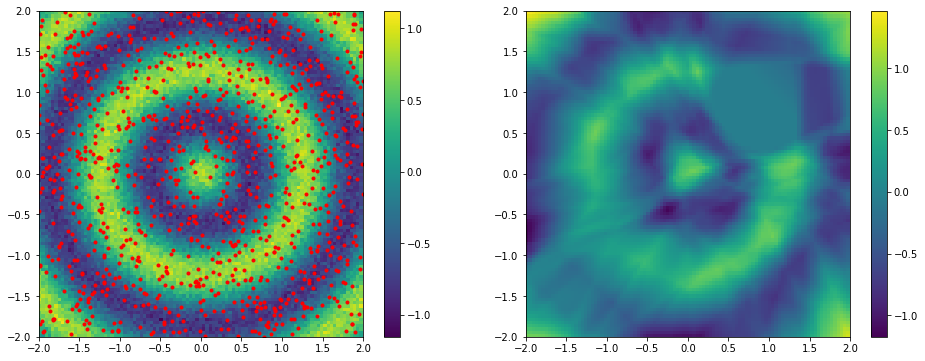

In [308]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=net.forward(x_test_2d)[0].reshape((n1,n1))
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


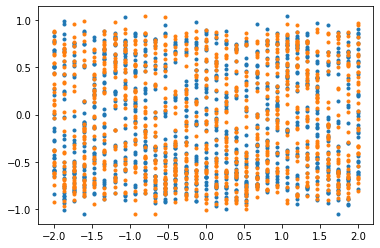

In [146]:

n_data=1001
# hidden_layers=[16,32,256,32,16]
hidden_layers=[16,16,16,16]
# hidden_layers=[64,128,128,64]
hidden_layers=[32,32,32,32]
n1=int(np.sqrt(n_data))
x1,x2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x=np.hstack([x1.reshape((n1*n1,1)),x2.reshape(n1*n1,1)])
# x=np.random.rand(n_data,2)*4-2
# y= 0.8*np.sin(x[:,0]*3.4)+0.8*np.sin(x[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
# y=y.reshape((y.shape[0],1))
y=test_fun_2d(x)
x_test=np.linspace(-2,2,1000).reshape(1000,1)
plt.plot(x,y,'.')
nnet=NNet(hidden_layer_sizes=hidden_layers,input_dim=2,output_dim=1,initialiser_function=initialiser_function2)

for ii in range(50):
    print(ii)
    nnet.train(x,y,print_error=False,alpha=0.01)
#     plt.plot(x_test,net.forward(x_test)[0])

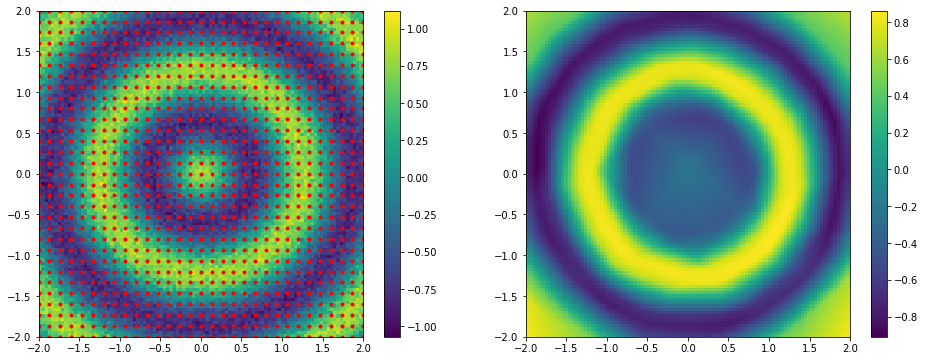

In [147]:
n1=100
x_test1,x_test2=np.meshgrid(np.linspace(-2,2,n1),np.linspace(-2,2,n1))
x_test_2d=np.hstack([x_test1.reshape((n1*n1,1)),x_test2.reshape(n1*n1,1)])
y_test_net_2d=nnet.forward(x_test_2d).reshape((n1,n1))
# print(y_test_net_2d.shape)
# y_test_2d= 0.8*np.sin(x_test_2d[:,0]*3.4)+0.8*np.sin(x_test_2d[:,1]*3)#+np.random.randn(x.shape[0],1)*0.1
y_test_2d=test_fun_2d(x_test_2d)
y_test_2d=y_test_2d.reshape((n1,n1))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pcolor(x_test1,x_test2,y_test_2d);
plt.colorbar()
plt.plot(x[:,0],x[:,1],'r.')
plt.subplot(1,2,2)
plt.pcolor(x_test1,x_test2,y_test_net_2d);
plt.colorbar()
# plt.plot(x[:,0],x[:,1],'r.')


In [843]:
n_data=10001
x=np.random.rand(n_data,1)*4-2
y= 0.8*np.sin(x*3.4)+np.random.randn(x.shape[0],x.shape[1])*0.1
net=NNet2(hidden_layer_sizes=[16,32,64],input_dim=1,output_dim=1,initialiser_function=initialiser_function2)
net.train(x,y,print_error=True)

0: Error: 334.35268309062906
1: Error: 554797.848962102
2: Error: 314101399663.7126
3: Error: 2.692941677171469e+51
4: Error: 1.4828564323933328e+202
5: Error: inf
6: Error: nan
7: Error: nan
8: Error: nan
9: Error: nan
10: Error: nan
11: Error: nan
12: Error: nan
13: Error: nan
14: Error: nan
15: Error: nan
16: Error: nan
17: Error: nan
18: Error: nan
19: Error: nan
20: Error: nan
21: Error: nan
22: Error: nan
23: Error: nan
24: Error: nan
25: Error: nan
26: Error: nan
27: Error: nan
28: Error: nan
29: Error: nan
30: Error: nan
31: Error: nan
32: Error: nan
33: Error: nan
34: Error: nan
35: Error: nan
36: Error: nan
37: Error: nan
38: Error: nan
39: Error: nan
40: Error: nan
41: Error: nan
42: Error: nan
43: Error: nan
44: Error: nan
45: Error: nan
46: Error: nan
47: Error: nan
48: Error: nan
49: Error: nan
50: Error: nan
51: Error: nan
52: Error: nan
53: Error: nan
54: Error: nan
55: Error: nan
56: Error: nan
57: Error: nan
58: Error: nan
59: Error: nan
60: Error: nan
61: Error: nan


/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in matmul
/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


239: Error: nan
240: Error: nan
241: Error: nan
242: Error: nan
243: Error: nan
244: Error: nan
245: Error: nan
246: Error: nan
247: Error: nan
248: Error: nan
249: Error: nan
250: Error: nan
251: Error: nan
252: Error: nan
253: Error: nan
254: Error: nan
255: Error: nan
256: Error: nan
257: Error: nan
258: Error: nan
259: Error: nan
260: Error: nan
261: Error: nan
262: Error: nan
263: Error: nan
264: Error: nan
265: Error: nan
266: Error: nan
267: Error: nan
268: Error: nan
269: Error: nan
270: Error: nan
271: Error: nan
272: Error: nan
273: Error: nan
274: Error: nan
275: Error: nan
276: Error: nan
277: Error: nan
278: Error: nan
279: Error: nan
280: Error: nan
281: Error: nan
282: Error: nan
283: Error: nan
284: Error: nan
285: Error: nan
286: Error: nan
287: Error: nan
288: Error: nan
289: Error: nan
290: Error: nan
291: Error: nan
292: Error: nan
293: Error: nan
294: Error: nan
295: Error: nan
296: Error: nan
297: Error: nan
298: Error: nan
299: Error: nan
300: Error: nan
301: Err

1277: Error: nan
1278: Error: nan
1279: Error: nan
1280: Error: nan
1281: Error: nan
1282: Error: nan
1283: Error: nan
1284: Error: nan
1285: Error: nan
1286: Error: nan
1287: Error: nan
1288: Error: nan
1289: Error: nan
1290: Error: nan
1291: Error: nan
1292: Error: nan
1293: Error: nan
1294: Error: nan
1295: Error: nan
1296: Error: nan
1297: Error: nan
1298: Error: nan
1299: Error: nan
1300: Error: nan
1301: Error: nan
1302: Error: nan
1303: Error: nan
1304: Error: nan
1305: Error: nan
1306: Error: nan
1307: Error: nan
1308: Error: nan
1309: Error: nan
1310: Error: nan
1311: Error: nan
1312: Error: nan
1313: Error: nan
1314: Error: nan
1315: Error: nan
1316: Error: nan
1317: Error: nan
1318: Error: nan
1319: Error: nan
1320: Error: nan
1321: Error: nan
1322: Error: nan
1323: Error: nan
1324: Error: nan
1325: Error: nan
1326: Error: nan
1327: Error: nan
1328: Error: nan
1329: Error: nan
1330: Error: nan
1331: Error: nan
1332: Error: nan
1333: Error: nan
1334: Error: nan
1335: Error: n

2099: Error: nan
2100: Error: nan
2101: Error: nan
2102: Error: nan
2103: Error: nan
2104: Error: nan
2105: Error: nan
2106: Error: nan
2107: Error: nan
2108: Error: nan
2109: Error: nan
2110: Error: nan
2111: Error: nan
2112: Error: nan
2113: Error: nan
2114: Error: nan
2115: Error: nan
2116: Error: nan
2117: Error: nan
2118: Error: nan
2119: Error: nan
2120: Error: nan
2121: Error: nan
2122: Error: nan
2123: Error: nan
2124: Error: nan
2125: Error: nan
2126: Error: nan
2127: Error: nan
2128: Error: nan
2129: Error: nan
2130: Error: nan
2131: Error: nan
2132: Error: nan
2133: Error: nan
2134: Error: nan
2135: Error: nan
2136: Error: nan
2137: Error: nan
2138: Error: nan
2139: Error: nan
2140: Error: nan
2141: Error: nan
2142: Error: nan
2143: Error: nan
2144: Error: nan
2145: Error: nan
2146: Error: nan
2147: Error: nan
2148: Error: nan
2149: Error: nan
2150: Error: nan
2151: Error: nan
2152: Error: nan
2153: Error: nan
2154: Error: nan
2155: Error: nan
2156: Error: nan
2157: Error: n

3012: Error: nan
3013: Error: nan
3014: Error: nan
3015: Error: nan
3016: Error: nan
3017: Error: nan
3018: Error: nan
3019: Error: nan
3020: Error: nan
3021: Error: nan
3022: Error: nan
3023: Error: nan
3024: Error: nan
3025: Error: nan
3026: Error: nan
3027: Error: nan
3028: Error: nan
3029: Error: nan
3030: Error: nan
3031: Error: nan
3032: Error: nan
3033: Error: nan
3034: Error: nan
3035: Error: nan
3036: Error: nan
3037: Error: nan
3038: Error: nan
3039: Error: nan
3040: Error: nan
3041: Error: nan
3042: Error: nan
3043: Error: nan
3044: Error: nan
3045: Error: nan
3046: Error: nan
3047: Error: nan
3048: Error: nan
3049: Error: nan
3050: Error: nan
3051: Error: nan
3052: Error: nan
3053: Error: nan
3054: Error: nan
3055: Error: nan
3056: Error: nan
3057: Error: nan
3058: Error: nan
3059: Error: nan
3060: Error: nan
3061: Error: nan
3062: Error: nan
3063: Error: nan
3064: Error: nan
3065: Error: nan
3066: Error: nan
3067: Error: nan
3068: Error: nan
3069: Error: nan
3070: Error: n

4011: Error: nan
4012: Error: nan
4013: Error: nan
4014: Error: nan
4015: Error: nan
4016: Error: nan
4017: Error: nan
4018: Error: nan
4019: Error: nan
4020: Error: nan
4021: Error: nan
4022: Error: nan
4023: Error: nan
4024: Error: nan
4025: Error: nan
4026: Error: nan
4027: Error: nan
4028: Error: nan
4029: Error: nan
4030: Error: nan
4031: Error: nan
4032: Error: nan
4033: Error: nan
4034: Error: nan
4035: Error: nan
4036: Error: nan
4037: Error: nan
4038: Error: nan
4039: Error: nan
4040: Error: nan
4041: Error: nan
4042: Error: nan
4043: Error: nan
4044: Error: nan
4045: Error: nan
4046: Error: nan
4047: Error: nan
4048: Error: nan
4049: Error: nan
4050: Error: nan
4051: Error: nan
4052: Error: nan
4053: Error: nan
4054: Error: nan
4055: Error: nan
4056: Error: nan
4057: Error: nan
4058: Error: nan
4059: Error: nan
4060: Error: nan
4061: Error: nan
4062: Error: nan
4063: Error: nan
4064: Error: nan
4065: Error: nan
4066: Error: nan
4067: Error: nan
4068: Error: nan
4069: Error: n

4560: Error: nan
4561: Error: nan
4562: Error: nan
4563: Error: nan
4564: Error: nan
4565: Error: nan
4566: Error: nan
4567: Error: nan
4568: Error: nan
4569: Error: nan
4570: Error: nan
4571: Error: nan
4572: Error: nan
4573: Error: nan
4574: Error: nan
4575: Error: nan
4576: Error: nan
4577: Error: nan
4578: Error: nan
4579: Error: nan
4580: Error: nan
4581: Error: nan
4582: Error: nan
4583: Error: nan
4584: Error: nan
4585: Error: nan
4586: Error: nan
4587: Error: nan
4588: Error: nan
4589: Error: nan
4590: Error: nan
4591: Error: nan
4592: Error: nan
4593: Error: nan
4594: Error: nan
4595: Error: nan
4596: Error: nan
4597: Error: nan
4598: Error: nan
4599: Error: nan
4600: Error: nan
4601: Error: nan
4602: Error: nan
4603: Error: nan
4604: Error: nan
4605: Error: nan
4606: Error: nan
4607: Error: nan
4608: Error: nan
4609: Error: nan
4610: Error: nan
4611: Error: nan
4612: Error: nan
4613: Error: nan
4614: Error: nan
4615: Error: nan
4616: Error: nan
4617: Error: nan
4618: Error: n

5042: Error: nan
5043: Error: nan
5044: Error: nan
5045: Error: nan
5046: Error: nan
5047: Error: nan
5048: Error: nan
5049: Error: nan
5050: Error: nan
5051: Error: nan
5052: Error: nan
5053: Error: nan
5054: Error: nan
5055: Error: nan
5056: Error: nan
5057: Error: nan
5058: Error: nan
5059: Error: nan
5060: Error: nan
5061: Error: nan
5062: Error: nan
5063: Error: nan
5064: Error: nan
5065: Error: nan
5066: Error: nan
5067: Error: nan
5068: Error: nan
5069: Error: nan
5070: Error: nan
5071: Error: nan
5072: Error: nan
5073: Error: nan
5074: Error: nan
5075: Error: nan
5076: Error: nan
5077: Error: nan
5078: Error: nan
5079: Error: nan
5080: Error: nan
5081: Error: nan
5082: Error: nan
5083: Error: nan
5084: Error: nan
5085: Error: nan
5086: Error: nan
5087: Error: nan
5088: Error: nan
5089: Error: nan
5090: Error: nan
5091: Error: nan
5092: Error: nan
5093: Error: nan
5094: Error: nan
5095: Error: nan
5096: Error: nan
5097: Error: nan
5098: Error: nan
5099: Error: nan
5100: Error: n

5524: Error: nan
5525: Error: nan
5526: Error: nan
5527: Error: nan
5528: Error: nan
5529: Error: nan
5530: Error: nan
5531: Error: nan
5532: Error: nan
5533: Error: nan
5534: Error: nan
5535: Error: nan
5536: Error: nan
5537: Error: nan
5538: Error: nan
5539: Error: nan
5540: Error: nan
5541: Error: nan
5542: Error: nan
5543: Error: nan
5544: Error: nan
5545: Error: nan
5546: Error: nan
5547: Error: nan
5548: Error: nan
5549: Error: nan
5550: Error: nan
5551: Error: nan
5552: Error: nan
5553: Error: nan
5554: Error: nan
5555: Error: nan
5556: Error: nan
5557: Error: nan
5558: Error: nan
5559: Error: nan
5560: Error: nan
5561: Error: nan
5562: Error: nan
5563: Error: nan
5564: Error: nan
5565: Error: nan
5566: Error: nan
5567: Error: nan
5568: Error: nan
5569: Error: nan
5570: Error: nan
5571: Error: nan
5572: Error: nan
5573: Error: nan
5574: Error: nan
5575: Error: nan
5576: Error: nan
5577: Error: nan
5578: Error: nan
5579: Error: nan
5580: Error: nan
5581: Error: nan
5582: Error: n

6045: Error: nan
6046: Error: nan
6047: Error: nan
6048: Error: nan
6049: Error: nan
6050: Error: nan
6051: Error: nan
6052: Error: nan
6053: Error: nan
6054: Error: nan
6055: Error: nan
6056: Error: nan
6057: Error: nan
6058: Error: nan
6059: Error: nan
6060: Error: nan
6061: Error: nan
6062: Error: nan
6063: Error: nan
6064: Error: nan
6065: Error: nan
6066: Error: nan
6067: Error: nan
6068: Error: nan
6069: Error: nan
6070: Error: nan
6071: Error: nan
6072: Error: nan
6073: Error: nan
6074: Error: nan
6075: Error: nan
6076: Error: nan
6077: Error: nan
6078: Error: nan
6079: Error: nan
6080: Error: nan
6081: Error: nan
6082: Error: nan
6083: Error: nan
6084: Error: nan
6085: Error: nan
6086: Error: nan
6087: Error: nan
6088: Error: nan
6089: Error: nan
6090: Error: nan
6091: Error: nan
6092: Error: nan
6093: Error: nan
6094: Error: nan
6095: Error: nan
6096: Error: nan
6097: Error: nan
6098: Error: nan
6099: Error: nan
6100: Error: nan
6101: Error: nan
6102: Error: nan
6103: Error: n

6615: Error: nan
6616: Error: nan
6617: Error: nan
6618: Error: nan
6619: Error: nan
6620: Error: nan
6621: Error: nan
6622: Error: nan
6623: Error: nan
6624: Error: nan
6625: Error: nan
6626: Error: nan
6627: Error: nan
6628: Error: nan
6629: Error: nan
6630: Error: nan
6631: Error: nan
6632: Error: nan
6633: Error: nan
6634: Error: nan
6635: Error: nan
6636: Error: nan
6637: Error: nan
6638: Error: nan
6639: Error: nan
6640: Error: nan
6641: Error: nan
6642: Error: nan
6643: Error: nan
6644: Error: nan
6645: Error: nan
6646: Error: nan
6647: Error: nan
6648: Error: nan
6649: Error: nan
6650: Error: nan
6651: Error: nan
6652: Error: nan
6653: Error: nan
6654: Error: nan
6655: Error: nan
6656: Error: nan
6657: Error: nan
6658: Error: nan
6659: Error: nan
6660: Error: nan
6661: Error: nan
6662: Error: nan
6663: Error: nan
6664: Error: nan
6665: Error: nan
6666: Error: nan
6667: Error: nan
6668: Error: nan
6669: Error: nan
6670: Error: nan
6671: Error: nan
6672: Error: nan
6673: Error: n

7157: Error: nan
7158: Error: nan
7159: Error: nan
7160: Error: nan
7161: Error: nan
7162: Error: nan
7163: Error: nan
7164: Error: nan
7165: Error: nan
7166: Error: nan
7167: Error: nan
7168: Error: nan
7169: Error: nan
7170: Error: nan
7171: Error: nan
7172: Error: nan
7173: Error: nan
7174: Error: nan
7175: Error: nan
7176: Error: nan
7177: Error: nan
7178: Error: nan
7179: Error: nan
7180: Error: nan
7181: Error: nan
7182: Error: nan
7183: Error: nan
7184: Error: nan
7185: Error: nan
7186: Error: nan
7187: Error: nan
7188: Error: nan
7189: Error: nan
7190: Error: nan
7191: Error: nan
7192: Error: nan
7193: Error: nan
7194: Error: nan
7195: Error: nan
7196: Error: nan
7197: Error: nan
7198: Error: nan
7199: Error: nan
7200: Error: nan
7201: Error: nan
7202: Error: nan
7203: Error: nan
7204: Error: nan
7205: Error: nan
7206: Error: nan
7207: Error: nan
7208: Error: nan
7209: Error: nan
7210: Error: nan
7211: Error: nan
7212: Error: nan
7213: Error: nan
7214: Error: nan
7215: Error: n

7986: Error: nan
7987: Error: nan
7988: Error: nan
7989: Error: nan
7990: Error: nan
7991: Error: nan
7992: Error: nan
7993: Error: nan
7994: Error: nan
7995: Error: nan
7996: Error: nan
7997: Error: nan
7998: Error: nan
7999: Error: nan
8000: Error: nan
8001: Error: nan
8002: Error: nan
8003: Error: nan
8004: Error: nan
8005: Error: nan
8006: Error: nan
8007: Error: nan
8008: Error: nan
8009: Error: nan
8010: Error: nan
8011: Error: nan
8012: Error: nan
8013: Error: nan
8014: Error: nan
8015: Error: nan
8016: Error: nan
8017: Error: nan
8018: Error: nan
8019: Error: nan
8020: Error: nan
8021: Error: nan
8022: Error: nan
8023: Error: nan
8024: Error: nan
8025: Error: nan
8026: Error: nan
8027: Error: nan
8028: Error: nan
8029: Error: nan
8030: Error: nan
8031: Error: nan
8032: Error: nan
8033: Error: nan
8034: Error: nan
8035: Error: nan
8036: Error: nan
8037: Error: nan
8038: Error: nan
8039: Error: nan
8040: Error: nan
8041: Error: nan
8042: Error: nan
8043: Error: nan
8044: Error: n

8586: Error: nan
8587: Error: nan
8588: Error: nan
8589: Error: nan
8590: Error: nan
8591: Error: nan
8592: Error: nan
8593: Error: nan
8594: Error: nan
8595: Error: nan
8596: Error: nan
8597: Error: nan
8598: Error: nan
8599: Error: nan
8600: Error: nan
8601: Error: nan
8602: Error: nan
8603: Error: nan
8604: Error: nan
8605: Error: nan
8606: Error: nan
8607: Error: nan
8608: Error: nan
8609: Error: nan
8610: Error: nan
8611: Error: nan
8612: Error: nan
8613: Error: nan
8614: Error: nan
8615: Error: nan
8616: Error: nan
8617: Error: nan
8618: Error: nan
8619: Error: nan
8620: Error: nan
8621: Error: nan
8622: Error: nan
8623: Error: nan
8624: Error: nan
8625: Error: nan
8626: Error: nan
8627: Error: nan
8628: Error: nan
8629: Error: nan
8630: Error: nan
8631: Error: nan
8632: Error: nan
8633: Error: nan
8634: Error: nan
8635: Error: nan
8636: Error: nan
8637: Error: nan
8638: Error: nan
8639: Error: nan
8640: Error: nan
8641: Error: nan
8642: Error: nan
8643: Error: nan
8644: Error: n

9106: Error: nan
9107: Error: nan
9108: Error: nan
9109: Error: nan
9110: Error: nan
9111: Error: nan
9112: Error: nan
9113: Error: nan
9114: Error: nan
9115: Error: nan
9116: Error: nan
9117: Error: nan
9118: Error: nan
9119: Error: nan
9120: Error: nan
9121: Error: nan
9122: Error: nan
9123: Error: nan
9124: Error: nan
9125: Error: nan
9126: Error: nan
9127: Error: nan
9128: Error: nan
9129: Error: nan
9130: Error: nan
9131: Error: nan
9132: Error: nan
9133: Error: nan
9134: Error: nan
9135: Error: nan
9136: Error: nan
9137: Error: nan
9138: Error: nan
9139: Error: nan
9140: Error: nan
9141: Error: nan
9142: Error: nan
9143: Error: nan
9144: Error: nan
9145: Error: nan
9146: Error: nan
9147: Error: nan
9148: Error: nan
9149: Error: nan
9150: Error: nan
9151: Error: nan
9152: Error: nan
9153: Error: nan
9154: Error: nan
9155: Error: nan
9156: Error: nan
9157: Error: nan
9158: Error: nan
9159: Error: nan
9160: Error: nan
9161: Error: nan
9162: Error: nan
9163: Error: nan
9164: Error: n

(1000, 1)


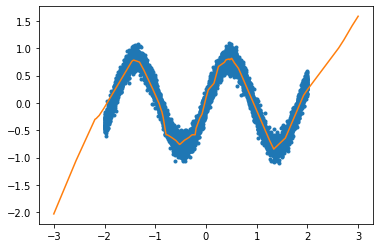

In [805]:
x_test=np.linspace(-3,3,1000).reshape(1000,1)
plt.plot(x,y,'.')
plt.plot(x_test,net.forward(x_test))
